# Notebook for SGAS1226 Stacked Flux Measurements

Paper Link: https://www.overleaf.com/5851713799ptkcrfvbggys

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from specutils.spectra import Spectrum1D
from specutils.fitting.continuum import fit_continuum
from specutils.fitting import fit_generic_continuum
from specutils.fitting import fit_lines
from specutils import SpectralRegion
from specutils.analysis import snr
from specutils.analysis import line_flux

from astropy.io import fits
import astropy.units as u
from astropy.modeling import models
from astropy.nddata import StdDevUncertainty
from astropy.visualization import LogStretch, ImageNormalize, SquaredStretch, ManualInterval, PowerStretch

import os

from importlib import reload

import entomology.bw_specstuff as bws
#import templates.spec as bws
import jwst_templates as tem

In [8]:
%matplotlib inline

In [32]:
reload(bws), reload(tem.spec)

(<module 'entomology.bw_specstuff' from '/Users/bdwelch1/code/entomology/bw_specstuff.py'>,
 <module 'jwst_templates.spec' from '/Users/bdwelch1/code/jwst_templates/spec.py'>)

In [98]:
# print out relevant line wavelengths:
print("[OIII] 4363:", bws.rest2obs(4363, 2.92))
print("[NII] 5755:", bws.rest2obs(5755, 2.92))
print("[SII] 6312:", bws.rest2obs(6312, 2.92))
print("[OII] 7320,7330:",bws.rest2obs(7320, 2.92), bws.rest2obs(7330, 2.92))
print('OII 3727:', bws.rest2obs(3727, 2.92))

print("zspec([OIII] 5007):", bws.get_redshift(0.5008, 1.96618))
#print('zspec Halpha:', bws.get_redshift(0.6565, ))
print("Hgamma:", bws.rest2obs(4340, 2.92))


[OIII] 4363: 17102.96
[NII] 5755: 22559.6
[SII] 6312: 24743.04
[OII] 7320,7330: 28694.399999999998 28733.6
OII 3727: 14609.84
zspec([OIII] 5007): 2.9260782747603833
Hgamma: 17012.8


In [63]:
# step one - extract a spectrum 
# First define some locations/filenames:

# main data cubes:
datadir = '/Users/bdwelch1/Documents/data/templates/sdss1226/nirspec/pmap1089/L3_destripe'
cubefile = 'SGAS1226-sigmaclipped-g235h-s3d_v2.fits'

# mask for extracting a fill 1D spectrum
maskdir = '/Users/bdwelch1/Documents/science/templates/ifu_masks'
maskfile = 'SGAS1226-mask-layers.fits' 


In [24]:
mask1 = fits.open(os.path.join(maskdir,maskfile))[1].data
mask2 = fits.open(os.path.join(maskdir,maskfile))[2].data
mask3 = fits.open(os.path.join(maskdir,maskfile))[3].data
allmask = mask1 + mask2 + mask3

In [30]:
try: len(3)
except TypeError: print('ope')
if len([2,3]): print('huzzah')

ope
huzzah


<IPython.core.display.Javascript object>


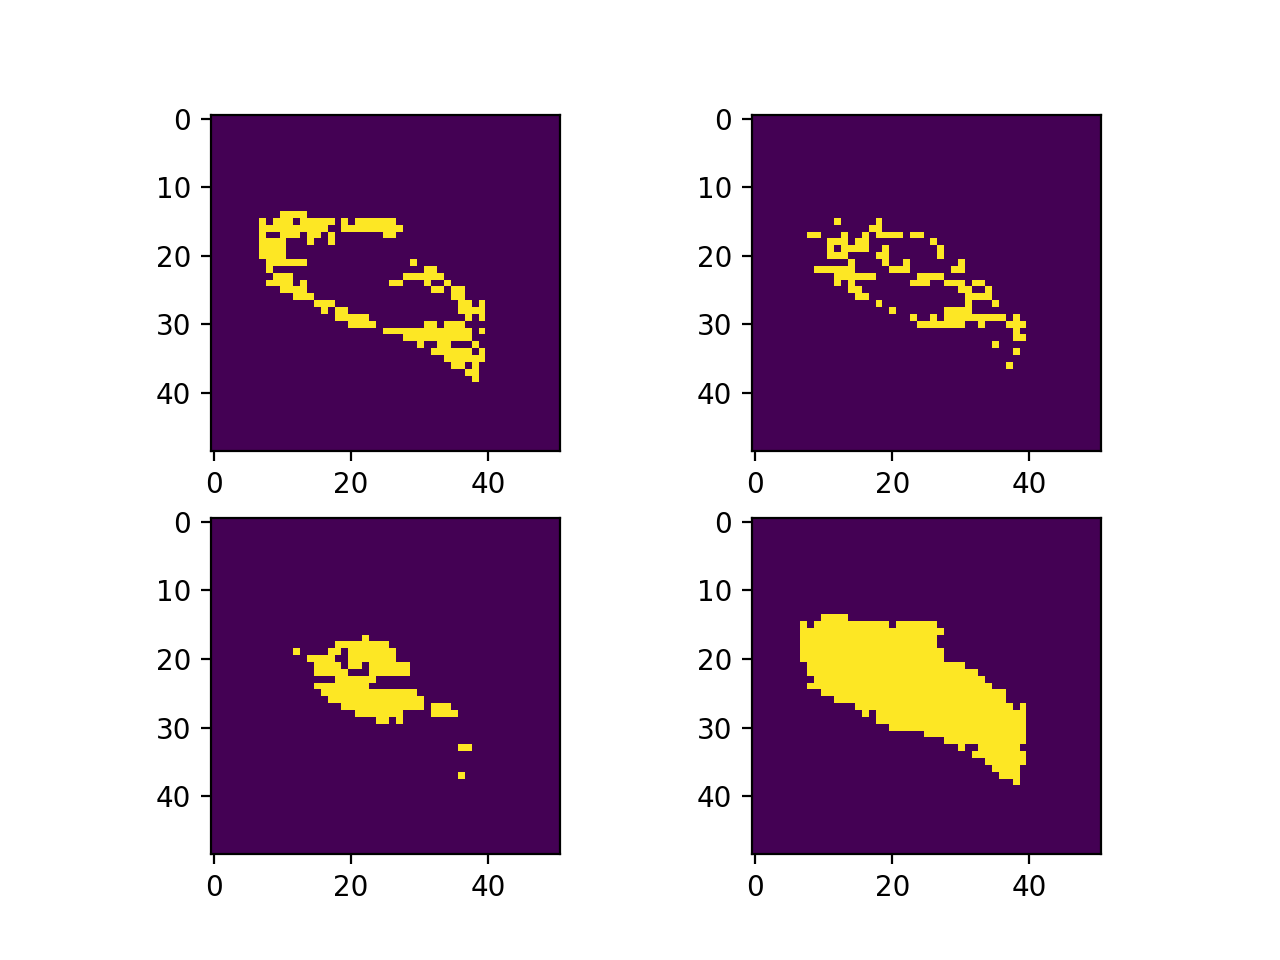

In [26]:
fig, ax = plt.subplots(2,2)
ax[0][0].imshow(mask1)
ax[0][1].imshow(mask2)
ax[1][0].imshow(mask3)
ax[1][1].imshow(allmask)
plt.show()

In [64]:
dfspec = tem.spec.integrate1D_mask(os.path.join(datadir, cubefile), 
                                   os.path.join(maskdir,maskfile),
                                   zsource=2.9255)#,
#                                   maskext=[2,3])

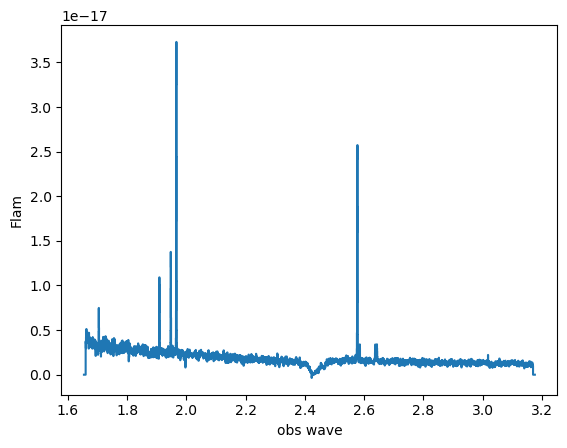

In [65]:
fig = plt.figure()
plt.step(dfspec["wave"], dfspec["flam"], where='mid')
plt.xlabel('obs wave')
plt.ylabel('Flam')
plt.show()

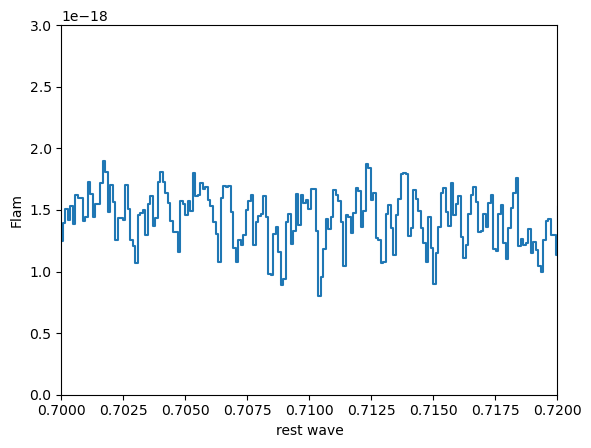

In [66]:
fig = plt.figure()
plt.step(dfspec["rest_wave"], dfspec["flam"], where='mid')
plt.xlabel('rest wave')
plt.ylabel('Flam')
plt.xlim(0.70,0.72)
plt.ylim(0,3e-18)
plt.show()

Now lets fit some continuum and emission lines!

In [67]:
box140 = tem.continuum.get_boxcar4autocont_nirspec('g235h','f170lp',zz=2.9255)
print(box140)
if box140 % 2 == 0: box140 += 1 # make it odd
print(box140)
cont140 = tem.continuum.fit_autocont(dfspec, zz=2.9255, boxcar=box140, v2mask=300,
                                    colwave='wave', colf='flam', colcont='flam_autocont')

101
101


In [8]:
lines = pd.read_csv('/Users/bdwelch1/code/jwst_templates/Reference_files/emission_lines_BWlocal.txt',
                       sep='\s+', skiprows=5)
zeros = np.zeros(len(lines))
lines['flux'] = zeros
lines['fluxerr'] = zeros
lines['dered_flux'] = zeros
lines['dered_fluxerr'] = zeros
lines['final_flux'] = zeros
lines['final_fluxerr'] = zeros
#lines

1.1465423169615996e-17 4.890339223434227
3.4849148459105835e-17 5.305520866482351
8.61879295369335e-18 4.840511125591581


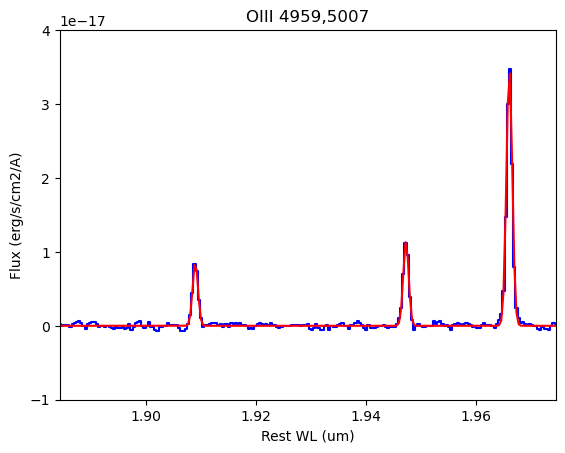

4959 flux,err: 1.405461676892829e-16 5.384994532757751e-18
5007 flux,err: 4.634577316369681e-16 6.4831090452162175e-18
OIII ratio: 3.2975479819668414 0.13450203938098815
Hbeta flux,err: 1.0457493535040503e-16 4.9954284320719166e-18


In [9]:
# great success! Now let's fit OIII!
scale=1e17
zsource = 2.9255

line5008 = [0.48*(1+zsource), 0.502*(1+zsource)]#SpectralRegion(0.495*u.um, 0.502*u.um) 
param_dictOIII = {
    "amplitude": [1,1,1],
    "wavelength": [4960*(1+zsource), 5008*(1+zsource), 4861*(1+zsource)],
    "width": [2, 2, 2]
}

f,ferr,poptOIII,pcovOIII = tem.spec.cont_sub_curvefit(dfspec,
                                                            line5008,
                                                            line_param_dict=param_dictOIII,
                                                            scale=scale,
                                                            obs_wl=True,
                                                            verbose=True)

f4960 = f[0]
f5008 = f[1]
fHb = f[2]
ferr4960 = ferr[0]
ferr5008 = ferr[1]
ferrHb = ferr[2]

fitresOIII = bws.multigauss2(dfspec.wave, poptOIII[0]/scale, poptOIII[1]/1e4,
                     poptOIII[2]/1e4, poptOIII[3]/scale, poptOIII[4]/1e4, poptOIII[5]/1e4,
                            poptOIII[6]/scale, poptOIII[7]/1e4, poptOIII[8]/1e4)

fig = plt.figure()

plt.step(dfspec.wave, dfspec.flam-dfspec.flam_autocont, 'b-', where='mid')
#plt.plot(contsub7330.spectral_axis, fit7330(wlarray), 'r-')
#plt.plot(contsub7320.spectral_axis, fit7320(wlarray), 'r-')
plt.plot(dfspec.wave, fitresOIII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('OIII 4959,5007')
plt.xlim(0.48*(1+zsource), 0.503*(1+zsource))
plt.ylim(-1e-17, 4e-17)
plt.show()

print("4959 flux,err:",f4960, ferr4960)
print("5007 flux,err:",f5008, ferr5008)
print("OIII ratio:", f5008/f4960, (f5008/f4960)*np.sqrt((ferr5008/f5008)**2+(ferr4960/f4960)**2))
print("Hbeta flux,err:",fHb, ferrHb)
# add it all to the df:
idx = lines.index[lines['restwave']==5008.240][0] # OIIIb
lines.at[idx,'flux'] = f5008
lines.at[idx, 'fluxerr'] = ferr5008
idx = lines.index[lines['restwave']==4960.295][0] #OIIIa
lines.at[idx,'flux'] = f4960
lines.at[idx, 'fluxerr'] = ferr4960
idx = lines.index[lines['restwave']==4862.683][0] #Hbeta
lines.at[idx,'flux'] = fHb
lines.at[idx, 'fluxerr'] = ferrHb


4.60857324363952e-18 4.297948580030814


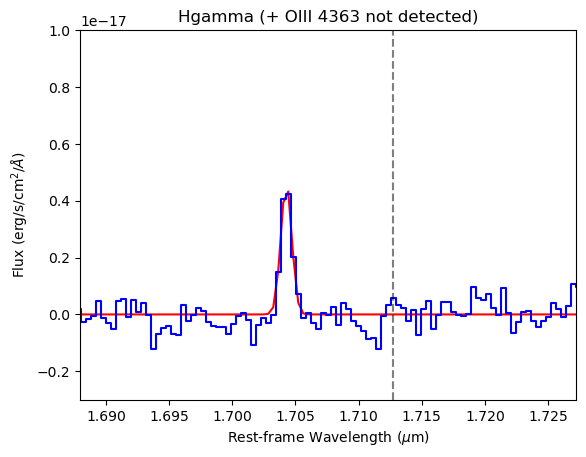

Hgamma:  [4.9649816029871334e-17] [6.599153800424287e-18]


In [10]:
# fit Hgamma by itself because OIII 4363 is absent
parsHg = {
    "amplitude": [1],
    "wavelength": [4341*(1+zsource)],#,.4363*(1+zsource)],
    "width": [1]
}
fluxHg, fluxerrHg, popt, pcov = tem.spec.cont_sub_curvefit(dfspec, 
                               line_region = [0.432*(1+zsource), 0.437*(1+zsource)], 
                               line_param_dict = parsHg,
                               verbose=True,
                                obs_wl=True,
                                scale=scale)


fitHg = tem.spec.multigauss(dfspec.wave, popt[0]/scale,popt[1]/1e4,popt[2]/1e4)#,
#                           popt[3]/scale, popt[4]/1e4,popt[5]/1e4)

fig = plt.figure()

#plt.errorbar(contsub4363.spectral_axis, contsub4363.flux.value, yerr=contsub4363.uncertainty.array, fmt='b-')
plt.plot(dfspec.wave, fitHg, 'r-')
plt.step(dfspec.wave, dfspec.flam - dfspec.flam_autocont, 'b-', where='mid')
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
plt.vlines(0.4363*(1+zsource), -3e-18, 1e-17, linestyle='dashed', colors='k', alpha=0.5)
plt.xlabel('Rest-frame Wavelength ($\mu$m)')
plt.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
plt.title('Hgamma (+ OIII 4363 not detected)')
plt.xlim(0.43*(1+zsource), 0.44*(1+zsource))
plt.ylim(-3e-18, 1e-17)
plt.show()

print("Hgamma: ", fluxHg, fluxerrHg)
#print(popt)
idx = lines.index[lines['restwave']==4341.684][0] #Hgamma
lines.at[idx,'flux'] = fluxHg
lines.at[idx, 'fluxerr'] = fluxerrHg


In [76]:
reload(bws)

<module 'entomology.bw_specstuff' from '/Users/bdwelch1/code/entomology/bw_specstuff.py'>

4.810178629595469e-18 4.686472125346885
5.276956288954307e-19 3.4


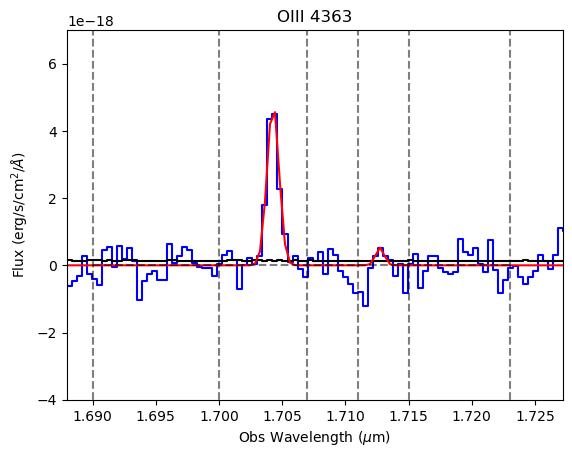

Hgamma:  5.650633982152744e-17 6.735529737149377e-18
OIII 4363:  4.497305064880812e-18 2.894556829676662e-18


In [94]:
# retry with a local subtraction and force a fit to 4363
from specutils.spectra import Spectrum1D
from specutils import SpectralRegion
from astropy.nddata import StdDevUncertainty

cont_bounds = [1.69,1.7,1.707,1.711,1.715,1.723]

# make a Spectrum1D object for use with existing local cont sub fitting code
cgs = u.erg * u.cm**-2 * u.s**-1 * u.AA**-1
wlarray = dfspec.wave.to_numpy()*u.um
fluxarray = dfspec.flam.to_numpy()*cgs
fluxerrarray = StdDevUncertainty(dfspec.flamerr.to_numpy())
spectrum4363 = Spectrum1D(spectral_axis=wlarray, flux=fluxarray, uncertainty=fluxerrarray)

# make cont region, line region, and line param dict
cont_region = SpectralRegion(cont_bounds[0]*u.um,cont_bounds[1]*u.um)+SpectralRegion(cont_bounds[2]*u.um,cont_bounds[3]*u.um)
cont_region += SpectralRegion(cont_bounds[4]*u.um,cont_bounds[5]*u.um)

line_region = SpectralRegion(cont_bounds[1]*u.um,cont_bounds[4]*u.um)

line_params_4363 = {
    "amplitude": [1,1],
    "wavelength": [4341*(1+zsource),4363.1*(1+zsource)],
    "width": [1,3.4]

}

fluxlist, fluxerrlist, popt4363loc, pcov4363loc, contsub_spec4363loc = bws.cont_sub_curvefit(
                spectrum4363, cont_region, line_region, line_params_4363, verbose = True, scale=1e18,
                fixed=[4,5])

fHg = fluxlist[0]
ferrHg = fluxerrlist[0]
f4363 = fluxlist[1]
ferr4363 = fluxerrlist[1]

fit4363 = bws.multigauss2(contsub_spec4363loc.spectral_axis.value, popt4363loc[0]/1e18,popt4363loc[1]/1e4,popt4363loc[2]/1e4,
                         popt4363loc[3]/1e18,popt4363loc[4]/1e4,popt4363loc[5]/1e4)

fig = plt.figure()

#plt.step(df140.wave, df140.flam, 'b-', where='mid')
#plt.step(df140.wave, df140.flam_autocont, 'r-', where='mid')
plt.step(contsub_spec4363loc.spectral_axis, contsub_spec4363loc.flux, 'b-', where='mid')
plt.step(contsub_spec4363loc.spectral_axis, contsub_spec4363loc.uncertainty.array, 'k-', where='mid')
plt.plot(contsub_spec4363loc.spectral_axis, fit4363, 'r-')
plt.vlines(cont_bounds,-5e-18,1e-17,colors='k',linestyles='--', alpha=0.5)
plt.hlines(0,cont_bounds[0],cont_bounds[-1],colors='k',linestyles='--', alpha=0.5)
plt.xlabel('Obs Wavelength ($\mu$m)')
plt.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
plt.title('OIII 4363')
plt.xlim(0.43*(1+zsource), 0.44*(1+zsource))
plt.ylim(-4e-18,.7e-17)
plt.show()


print("Hgamma: ", fHg, ferrHg)
print("OIII 4363: ", f4363, ferr4363)
#idx = lines.index[lines['restwave']==6302.046][0] # OI
#lines.at[idx,'flux'] = f6300
#lines.at[idx, 'fluxerr'] = ferr6300
#idx = lines.index[lines['restwave']==6313.8][0] # SIII
#lines.at[idx,'flux'] = f6312
#lines.at[idx, 'fluxerr'] = ferr6312


In [81]:
popt4363loc

array([4.81017908e+00, 1.70427463e+04, 4.68647123e+00, 4.81415160e-01,
       1.71280356e+04, 4.00000000e+00])

In [95]:
max(contsub_spec4363loc.uncertainty.array)

2.4432462289353236e-19

6.12105750313314e-19 4.993397568261791
2.4315923042824422e-17 6.4859224907045
1.817222720209307e-18 -5.112273231615282


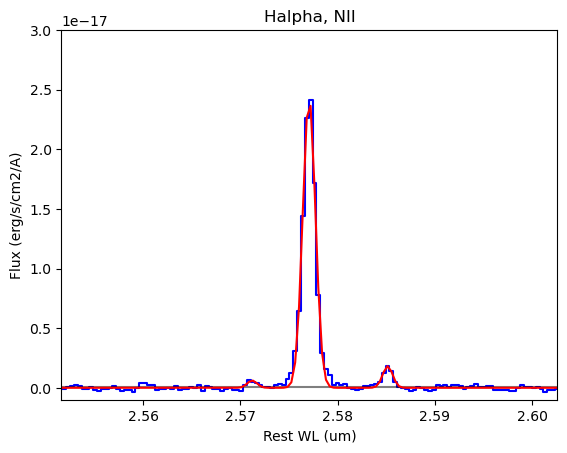

N2a flux,err: 7.661477650496192e-18 4.33365627214089e-18
N2b flux,err: 2.3286925264128464e-17 4.665611221071953e-18
Halpha flux,err: 3.9532333345816083e-16 6.359963361078821e-18


In [12]:
scale=1e16
lineHa = [0.652*(1+zsource), 0.66*(1+zsource)]#SpectralRegion(0.495*u.um, 0.502*u.um) 
param_dictHa = {
    "amplitude": [1,1,1],
    "wavelength": [6550*(1+zsource), 6564*(1+zsource), 6585*(1+zsource)],
    "width": [3, 1,1]
}

f,ferr,poptHa,pcovHa = tem.spec.cont_sub_curvefit(dfspec,
                                                    lineHa,
                                                    line_param_dict=param_dictHa,
                                                    scale=scale,
                                                    obs_wl=True,
                                                    verbose=True)

fN2a = f[0]
fHa = f[1]
fN2b = f[2]
ferrN2a = ferr[0]
ferrHa = ferr[1]
ferrN2b = ferr[2]

fitresOIII = bws.multigauss2(dfspec.wave, poptHa[0]/scale, poptHa[1]/1e4,
                     poptHa[2]/1e4, poptHa[3]/scale, poptHa[4]/1e4, poptHa[5]/1e4,
                            poptHa[6]/scale, poptHa[7]/1e4, poptHa[8]/1e4)

fig = plt.figure()

plt.step(dfspec.wave, dfspec.flam-dfspec.flam_autocont, 'b-', where='mid')
plt.step(dfspec.wave, dfspec.flamerr, 'k-', where='mid', alpha=0.5)
#plt.plot(contsub7330.spectral_axis, fit7330(wlarray), 'r-')
#plt.plot(contsub7320.spectral_axis, fit7320(wlarray), 'r-')
plt.plot(dfspec.wave, fitresOIII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('Halpha, NII')
plt.xlim(0.65*(1+zsource), 0.663*(1+zsource))
plt.ylim(-1e-18, 3e-17)
plt.show()

print("N2a flux,err:",fN2a, ferrN2a)
print("N2b flux,err:",fN2b, ferrN2b)
#print("OIII ratio:", f5008/f4960)
print("Halpha flux,err:",fHa, ferrHa)
idx = lines.index[lines['restwave']==6549.85][0] # NIIa
lines.at[idx,'flux'] = fN2a
lines.at[idx, 'fluxerr'] = ferrN2a
idx = lines.index[lines['restwave']==6585.28][0] # NIIb
lines.at[idx,'flux'] = fN2b
lines.at[idx, 'fluxerr'] = ferrN2b
idx = lines.index[lines['restwave']==6564.61][0] # Halpha
lines.at[idx,'flux'] = fHa
lines.at[idx, 'fluxerr'] = ferrHa


1.6849448765587443e-18 8.870240891079797
1.6873513578325582e-18 8.481127157223423


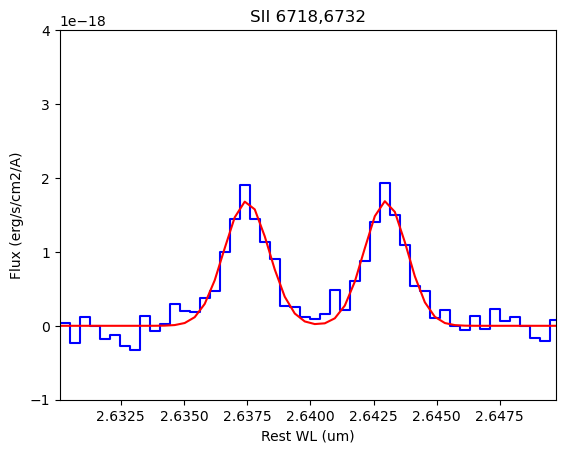

6718 flux,err: 3.74637326688653e-17 3.1956044930260292e-18
6732 flux,err: 3.587145842323744e-17 3.3078694743302934e-18
SII ratio: 0.9574982487809833


In [13]:
scale=1e17
line6718 = [0.67*(1+zsource), 0.675*(1+zsource)]#SpectralRegion(0.495*u.um, 0.502*u.um) 
param_dictSII = {
    "amplitude": [1,1],
    "wavelength": [6718*(1+zsource), 6732*(1+zsource)],
    "width": [1, 1]
}

f,ferr,poptSII,pcovSII = tem.spec.cont_sub_curvefit(dfspec,
                                                            line6718,
                                                            line_param_dict=param_dictSII,
                                                            scale=scale,
                                                            obs_wl=True,
                                                            verbose=True)

f6718 = f[0]
f6732 = f[1]
ferr6718 = ferr[0]
ferr6732 = ferr[1]

fitSII = bws.multigauss2(dfspec.wave, poptSII[0]/scale, poptSII[1]/1e4,
                     poptSII[2]/1e4,poptSII[3]/scale,poptSII[4]/1e4, poptSII[5]/1e4)

fig = plt.figure()

plt.step(dfspec.wave, dfspec.flam-dfspec.flam_autocont, 'b-', where='mid')
#plt.plot(contsub7330.spectral_axis, fit7330(wlarray), 'r-')
#plt.plot(contsub7320.spectral_axis, fit7320(wlarray), 'r-')
plt.plot(dfspec.wave, fitSII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('SII 6718,6732')
plt.xlim(0.67*(1+zsource), 0.675*(1+zsource))
plt.ylim(-1e-18, 4e-18)
plt.show()

print("6718 flux,err:",f6718, ferr6718)
print("6732 flux,err:",f6732, ferr6732)
print("SII ratio:", f6732/f6718)
idx = lines.index[lines['restwave']==6718.29][0] # SIIa
lines.at[idx,'flux'] = f6718
lines.at[idx, 'fluxerr'] = ferr6718
idx = lines.index[lines['restwave']==6732.67][0] # SIIb
lines.at[idx,'flux'] = f6732
lines.at[idx, 'fluxerr'] = ferr6732


In [14]:
reload(tem.spec)
print(0.436*(1+zsource),0.437*(1+zsource))

1.711518 1.7154435


In [15]:
# now we get the [OIII]4363 upper limit:
o3_4363_uplim = tem.spec.get_uplim(dfspec, 
                          (0.4355*(1+zsource),0.437*(1+zsource)), # linereg - 0.0015
                          (0.437*(1+zsource),0.44*(1+zsource))) # contreg - 0.003
# and NII 5755:
n2_5755_uplim = tem.spec.get_uplim(dfspec, 
                          (0.5752*(1+zsource),0.5759*(1+zsource)), # 0.0007
                          (0.57*(1+zsource),0.575*(1+zsource),0.576*(1+zsource),0.582*(1+zsource))) # 0.011
# and SIII 6312
s3_6312_uplim = tem.spec.get_uplim(dfspec, 
                          (0.63118*(1+zsource),0.63169*(1+zsource)), # 0.00051
                          (0.632*(1+zsource),0.636*(1+zsource))) # 0.004
# and OII 7320
o2_7320_uplim = tem.spec.get_uplim(dfspec, 
                          (0.7318*(1+zsource),0.7327*(1+zsource)), # 0.0009 
                          (0.729*(1+zsource),0.731*(1+zsource),0.734*(1+zsource),0.737*(1+zsource))) # 0.005
# and OII 7330
o2_7330_uplim = tem.spec.get_uplim(dfspec, 
                          (0.7328*(1+zsource),0.7337*(1+zsource)), # 0.0009
                          (0.729*(1+zsource),0.731*(1+zsource),0.734*(1+zsource),0.737*(1+zsource))) # 0.005

# print 'em!
print('[OIII]4363: <',o3_4363_uplim)
print('[NII]5755: <',n2_5755_uplim)
print('[SIII]6321: <',s3_6312_uplim)
print('[OII]7320: <',o2_7320_uplim)
print('[OII]7330: <',o2_7330_uplim)


No line detected! Significance: -2.20
-3.3733220756947534e-18
No line detected! Significance: 0.63
2.645505609462428e-19
No line detected! Significance: 1.02
3.5060044420475317e-19
No line detected! Significance: -3.21
-8.714127752566788e-19
No line detected! Significance: -0.74
-2.0363632218935674e-19
[OIII]4363: < 4.604445949503737e-18
[NII]5755: < 1.2512309368970169e-18
[SIII]6321: < 1.0280978298010776e-18
[OII]7320: < 8.1547749997584e-19
[OII]7330: < 8.244048492039034e-19


In [46]:
ar3_7138_uplim = tem.spec.get_uplim(dfspec, 
                          (0.7125*(1+zsource),0.7145*(1+zsource)), # linereg
                          (0.7025*(1+zsource),0.7125*(1+zsource))) # contreg



No line detected! Significance: 1.63
1.3483853923638723e-18


In [16]:
# add uplims to flux table
idx = lines.index[lines['restwave']==4364.4360][0] # OIII
lines.at[idx, 'flux'] = o3_4363_uplim
lines.at[idx, 'fluxerr'] = -1

idx = lines.index[lines['restwave']==5756.240][0] # NII
lines.at[idx, 'flux'] = n2_5755_uplim
lines.at[idx, 'fluxerr'] = -1

idx = lines.index[lines['restwave']==6313.8][0] # SIII
lines.at[idx, 'flux'] = s3_6312_uplim
lines.at[idx, 'fluxerr'] = -1

idx = lines.index[lines['restwave']==7322.01][0] # OIIa
lines.at[idx, 'flux'] = o2_7320_uplim
lines.at[idx, 'fluxerr'] = -1

idx = lines.index[lines['restwave']==7331.68][0] # OIIb
lines.at[idx, 'flux'] = o2_7330_uplim
lines.at[idx, 'fluxerr'] = -1

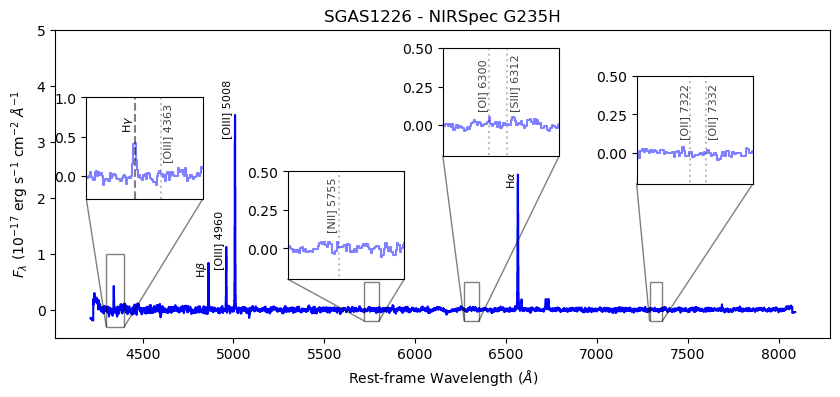

In [15]:
# nice-ish line fit figure:
# start w/ full spectrum, include zoom-in boxes for each auroral line, w/ fits for all but NII

fig, ax = plt.subplots(figsize=(10,4))

ax.step(dfspec.rest_wave*1e4, (dfspec.flam-dfspec.flam_autocont)*1e17, 'b-', where='mid')
ax.set_ylim(-.5,5)
ax.set_xlabel("Rest-frame Wavelength ($\AA$)")
ax.set_ylabel('$F_{\lambda}$ ($10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$')
ax.set_title('SGAS1226 - NIRSpec G235H')
ax.text(5008-70, 3.1, '[OIII] 5008', fontsize=8, rotation='vertical') 
ax.text(4960-65, 0.75, '[OIII] 4960', fontsize=8, rotation='vertical') 
ax.text(4861-70, 0.65, 'H$\\beta$', fontsize=8, rotation='vertical') 
ax.text(6565-70, 2.2, 'H$\\alpha$', fontsize=8, rotation='vertical') 

axins1 = ax.inset_axes([0.04,0.45,0.15,0.33])
#axins1.plot(df140.rest_wave, fit4363, 'r-')
axins1.step(dfspec.rest_wave*1e4, (dfspec.flam - dfspec.flam_autocont)*1e17, 'b-', where='mid', alpha=0.5)
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
#axins1.xlabel('Rest-frame Wavelength ($\mu$m)')
#axins1.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
axins1.text(.4366*1e4,.2,'[OIII] 4363',fontsize=8,rotation='vertical',alpha=0.75)
axins1.text(.433*1e4,.6,'H$\gamma$',fontsize=8,rotation='vertical')
axins1.vlines(.4364*1e4,-.3, 1, linestyles=':',colors='k',alpha=0.25)
axins1.vlines(.434168*1e4,-.3, 1, linestyles='dashed',colors='k',alpha=0.5)
axins1.set_xlim(0.43*1e4, 0.44*1e4)
axins1.set_xticks([])
axins1.set_ylim(-.3, 1)
ax.indicate_inset_zoom(axins1,edgecolor='k')


axins3 = ax.inset_axes([0.5,0.59,0.15,0.35])
#axins3.plot(df140.rest_wave, fit6312, 'r-')
axins3.step(dfspec.rest_wave*1e4, (dfspec.flam - dfspec.flam_autocont)*1e17, 'b-', where='mid', alpha=0.5)
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
#axins1.xlabel('Rest-frame Wavelength ($\mu$m)')
#axins1.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
axins3.text(.6316*1e4,.1,'[SIII] 6312',fontsize=8,rotation='vertical',alpha=0.75)
axins3.text(.6294*1e4,.1,'[OI] 6300',fontsize=8,rotation='vertical',alpha=0.75)
axins3.vlines([.6302*1e4,.6314*1e4],-3, 1, linestyles=':',colors='k',alpha=0.25)
axins3.set_xlim(0.627*1e4, 0.635*1e4)
axins3.set_ylim(-.2, .5)
axins3.set_xticks([])
ax.indicate_inset_zoom(axins3,edgecolor='k')


axins4 = ax.inset_axes([0.75,0.5,0.15,0.35])
#axins4.plot(df140.rest_wave, fitOII, 'r-')
axins4.step(dfspec.rest_wave*1e4, (dfspec.flam - dfspec.flam_autocont)*1e17, 'b-', where='mid', alpha=0.5)
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
#axins1.xlabel('Rest-frame Wavelength ($\mu$m)')
#axins1.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
axins4.text(.7316*1e4,.1,'[OII] 7322',fontsize=8,rotation='vertical',alpha=0.75)
axins4.text(.7333*1e4,.1,'[OII] 7332',fontsize=8,rotation='vertical',alpha=0.75)
axins4.vlines([.7322*1e4,.7332*1e4],-.3, 1, linestyles=':',colors='k',alpha=0.25)
axins4.set_xlim(0.729*1e4, 0.736*1e4)
axins4.set_ylim(-.2, .5)
axins4.set_xticks([])
ax.indicate_inset_zoom(axins4,edgecolor='k')


axins5 = ax.inset_axes([0.3,0.19,0.15,0.35])
#axins3.plot(df140.rest_wave, fit6312, 'r-')
axins5.step(dfspec.rest_wave*1e4, (dfspec.flam - dfspec.flam_autocont)*1e17, 'b-', where='mid', alpha=0.5)
#plt.step(spectrum_g140h.spectral_axis, spectrum_g140h.flux, 'g-', where='mid')
#axins1.xlabel('Rest-frame Wavelength ($\mu$m)')
#axins1.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
axins5.text(.5747*1e4,.12,'[NII] 5755',fontsize=8,rotation='vertical',alpha=0.75)
axins5.vlines(.5755*1e4,-3, 10, linestyles=':',colors='k',alpha=0.25)
axins5.set_xlim(0.572*1e4, 0.58*1e4)
axins5.set_ylim(-.2, .5)
axins5.set_xticks([])
ax.indicate_inset_zoom(axins5,edgecolor='k')


#plt.savefig('auroral/sgas1226_g235_speczoom_draft2.png')
plt.show()

## Here we go...Pyneb time!
Lets see what we can do with this right here

In [5]:
import pyneb as pn

In [6]:
# define some functions to get uncertainties on temp, density, abundance:
# written by Danielle Berg, provided by Grace Olivier

# GET_TEMDEN_ERR: Determine the direct temp or dens for a given line ratio + error
#         INPUTS:       key - which diagnostic you are using
#                     ratio - line ratio corresponding to the diagnostic key
#                 ratio_err - uncertainty on the diagnostic line ratio
#                     niter - how many random samplings of a normal distribution with
#                             (center,width) = (ratio,ratio_err) to use in calculation
#
#----------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------
def get_temden_err(key, ratio, ratio_err, temdenin, niter, verbose=False):
    temdeno = np.zeros([niter])
    x       = np.random.normal(ratio, ratio_err, niter)
    # tem diagnostics:
    if key == 'Ne3':
        temdeno = Ne3.getTemDen(x,den=temdenin,wave1=3868,wave2=3342)
    if key == 'O3':
        temdeno = O3.getTemDen(x,den=temdenin,wave1=4363,wave2=5007)
    if key == 'O3uv':
        temdeno = O3.getTemDen(x,den=temdenin,wave1=1666,wave2=5007)
    if key == 'N2':
        temdeno = N2.getTemDen(x,den=temdenin,wave1=5755,wave2=6584)
    if key == 'S3':
        temdeno = S3.getTemDen(x,den=temdenin,wave1=6312,wave2=9532)
    if key == 'S2':
        temdeno = S2.getTemDen(x,den=temdenin,to_eval='(L(4069)+L(4076))/(L(6717)+L(6731))')
    if key == 'O2':
        temdeno = O2.getTemDen(x,den=temdenin,to_eval='(L(3726)+L(3729))/(L(7319)+L(7320)+L(7331)+L(7333))')
    # den diagnostics:
    if key == 'NS2':
        temdeno = S2.getTemDen(x,tem=temdenin,wave1=6717,wave2=6731)
    if key == 'Ar4':
        temdeno = Ar4.getTemDen(x,tem=temdenin,wave1=4711,wave2=4740)
    if key == 'C3':
        temdeno = C3.getTemDen(x,tem=temdenin,wave1=1907,wave2=1909)
    if key == 'Si3':
        temdeno = Si3.getTemDen(x,tem=temdenin,wave1=1883,wave2=1892)
    if key == 'Cl3':
        temdeno = Cl3.getTemDen(x,tem=temdenin,wave1=5517,wave2=5537)
    if verbose:
        return  np.median(temdeno[(np.nan_to_num(temdeno) > 0.)]), np.std(temdeno[(np.nan_to_num(temdeno) > 0.)]), temdeno
    else:
        return  np.median(temdeno[(np.nan_to_num(temdeno) > 0.)]), np.std(temdeno[(np.nan_to_num(temdeno) > 0.)])
#----------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------
"""
GET_IABUND_ERR: Determine an ion abundance and error due to flux unc and emis unc (temp)
        INPUTS:       key - which ion you are using
                      rat - emission line intensity corresponding to the ion key
                     rate - uncertainty rat
                      lam - wavelength of the emission line of interest
                     dens - electron density for the ion of interest
                      tem - electron temperature for the ion of interest
                     teme - uncertainty on tem
		OUTPUTS:     abund, err
"""
def get_iabund_err(key, lam, ratio, ratio_err, dens, tem, teme):
    niter = 1000
    iabund = np.zeros([niter])
    x      = np.random.normal(ratio, ratio_err, niter)
    y      = np.random.normal(tem,   teme,      niter)
    z      = y*0. + dens
    if key == 'O4':   iabund = O4.getIonAbundance (int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'O3':   iabund = O3.getIonAbundance (int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'O2b':  iabund = O2.getIonAbundance (int_ratio=x*100,tem=y,den=z,to_eval='L(3726)+L(3728)')
    if key == 'O2r':  iabund = O2.getIonAbundance( int_ratio=x*100,tem=y,den=z,
                                                  to_eval='L(7319)+L(7320)+L(7331)+L(7332)')
    if key == 'O1':   iabund = O1.getIonAbundance( int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'N3':   iabund = N3.getIonAbundance( int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'N2':   iabund = N2.getIonAbundance( int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'S3':   iabund = S3.getIonAbundance( int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'S2':   iabund = S2.getIonAbundance( int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Ne3':  iabund = Ne3.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Ne2':  iabund = N32.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Ar4':  iabund = Ar4.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Ar3':  iabund = Ar3.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'C3':   iabund = C3.getIonAbundance( int_ratio=x*100,tem=y,den=z,to_eval='L(1907)+L(1909)')
    if key == 'C4':   iabund = C4.getIonAbundance( int_ratio=x*100,tem=y,den=z,to_eval='L(1548)+L(1550)')
    if key == 'Fe2':  iabund = Fe2.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Fe3':  iabund = Fe3.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Fe4':  iabund = Fe4.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    if key == 'Fe5':  iabund = Fe5.getIonAbundance(int_ratio=x*100,tem=y,den=z,wave=lam)
    return  np.median(iabund[(np.nan_to_num(iabund) > 0.)]), np.std(iabund[(np.nan_to_num(iabund) > 0.)])

In [32]:
# From Danielle Berg's code - check if these are any different from the default?
DataFileDict = {'O2':  {'atom':'o_ii_atom_FFT04.dat',  'coll':'o_ii_coll_Kal09.dat'},
                'O3':  {'atom':'o_iii_atom_FFT04.dat', 'coll':'o_iii_coll_AK99.dat'},
                'N2':  {'atom':'n_ii_atom_FFT04.dat',  'coll':'n_ii_coll_T11.dat'}}#,
                #'Ne3': {'atom':'ne_iii_atom_FFT04.dat','coll':'ne_iii_coll_McLB00.dat'},
                #'Ar3': {'atom':'ar_iii_atom_MZ83.dat', 'coll':'ar_iii_coll_MB09.dat'},
                #'S2':  {'atom':'s_ii_atom_PKW09.dat',  'coll':'s_ii_coll_TZ10.dat'},
                #'S3':  {'atom':'s_iii_atom_PKW09.dat', 'coll':'s_iii_coll_HRS12.dat'}}
pn.atomicData.setDataFileDict(DataFileDict)

In [33]:
# define some atoms! these will be good to have later
# Low Ionization:
O2  = pn.Atom('O',2)
N2  = pn.Atom('N',2)
S2  = pn.Atom('S',2)
# High Ionization:
O3 = pn.Atom('O',3)
S3 = pn.Atom('S',3)

In [34]:
print(O3.atomFile, O3.collFile)
print(O2.atomFile, O2.collFile)
print(S3.atomFile, S3.collFile)
print(S2.atomFile, S2.collFile)
print(N2.atomFile, N2.collFile)

o_iii_atom_FFT04.dat o_iii_coll_AK99.dat
o_ii_atom_FFT04.dat o_ii_coll_Kal09.dat
s_iii_atom_FFTI06.dat s_iii_coll_TG99.dat
s_ii_atom_RGJ19.dat s_ii_coll_TZ10.dat
n_ii_atom_FFT04.dat n_ii_coll_T11.dat


In [7]:
# Galactic dust correction!
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarWebQuery

RV = 3.1

bayestar = BayestarWebQuery(version='bayestar2019') # originally was 2015, but use 2019 for now

ra, dec = 186.7, 21.9 # center of 
coo = SkyCoord(ra, dec, frame='fk5', unit='deg')
gal_ebv = np.max(bayestar(coo, mode='median'))
print(gal_ebv)
gc  = pn.RedCorr(E_BV = gal_ebv, law ='CCM89')
#fgc  = flux[:,j]*gc.getCorr(wave)
#fgce = err[:,j]*gc.getCorr(wave) 

Response received from server:
<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request.  Either the server is overloaded or there is an error in the application.</p>



HTTPError: 500 Server Error: INTERNAL SERVER ERROR for url: http://argonaut.skymaps.info/api/v2/bayestar2019/query

In [23]:
zsource = 2.9255
for i,line in lines.iterrows():
    flx = line['flux']
    flxer = line['fluxerr']
    wl = line['restwave']
    if flx != 0:
        # QUESTION! - do I need to redshift these lines? 
        # probably? Because this is galactic extinction from the milky way?
        dred = flx*gc.getCorr(wl*(1+zsource))
        dreder = flxer*gc.getCorr(wl*(1+zsource))
        lines.at[i,'dered_flux'] = dred
        lines.at[i,'dered_fluxerr'] = dreder


In [24]:
# now get internal gas dust correction (probably very low)
# first, get theoretical Ha/Hb ratio
H1 = pn.RecAtom('H', 1)
Hbeta_t1 = H1.getEmissivity(tem=1e4, den=1e2, lev_i=4, lev_j=2)
Halpha_t1 = H1.getEmissivity(tem=1e4, den=1e2, lev_i=3, lev_j=2)
print(Halpha_t1/Hbeta_t1)
HaHb_t1 = Halpha_t1/Hbeta_t1

# now what is the actual ratio?
dered_hbeta = lines.loc[lines['restwave']==4862.683]['flux'].values[0]
dered_halpha = lines.loc[lines['restwave']==6564.61]['flux'].values[0]
print(dered_halpha/dered_hbeta)
meas_HaHb = dered_halpha/dered_hbeta

rc = pn.RedCorr(E_BV = gal_ebv, law ='CCM89')
rc.setCorr(obs_over_theo=meas_HaHb / HaHb_t1, wave1=6563., wave2=4861.)
print(f'E(B-V), Halpha/Hbeta: {rc.E_BV}')
print(rc.getCorr(5008))

2.863157894736842
3.7802876199113014
E(B-V), Halpha/Hbeta: 0.28085629693830927
2.4548834959288137


In [25]:
# get initial temp measurement
dered_o3_4363 = lines.loc[lines['restwave']==4364.436]['dered_flux'].values[0] * rc.getCorr(4364.436)
#dered_o3_4363_err = lines.loc[lines['restwave']==4364.436]['dered_fluxerr'].values[0] * rc.getCorr(4364.436)
dered_o3_5007 = lines.loc[lines['restwave']==5008.24]['dered_flux'].values[0] * rc.getCorr(5008.24)
#dered_o3_5007_err = lines.loc[lines['restwave']==5008.24]['dered_fluxerr'].values[0] * rc.getCorr(5008.24)
to3r = dered_o3_4363 / dered_o3_5007
#to3re = np.sqrt((dered_o3_4363_err/dered_o3_4363)**2 + (dered_o3_5007_err/dered_o3_5007)**2) * to3r
to3n = O3.getTemDen(int_ratio=to3r, den=100., wave1=4364, wave2=5008)
print(f'4363/5007 ratio: < {to3r}')
print(f'T_O3: {to3n}')

4363/5007 ratio: < 0.011830230573183055
T_O3: 12159.129867238613


In [26]:
# get initial density measurement
dered_s2_6717 = lines.loc[lines['restwave']==6718.29]['dered_flux'].values[0] * rc.getCorr(6718.29)
dered_s2_6717_err = lines.loc[lines['restwave']==6718.29]['dered_fluxerr'].values[0] * rc.getCorr(6718.29)
dered_s2_6731 = lines.loc[lines['restwave']==6732.67]['dered_flux'].values[0] * rc.getCorr(6732.67)
dered_s2_6731_err = lines.loc[lines['restwave']==6732.67]['dered_fluxerr'].values[0] * rc.getCorr(6732.67)
ns2r = dered_s2_6717 / dered_s2_6731
ns2re = np.sqrt((dered_s2_6717_err/dered_s2_6717)**2 + (dered_s2_6731_err/dered_s2_6731)**2)*ns2r
ns2 = S2.getTemDen(int_ratio=ns2r, tem=to3n, wave1=6718, wave2=6732)
print(f'6717/6731: {ns2r} +- {ns2re}')
print(f'N_S2: {ns2}')

6717/6731: 1.0462489908518073 +- 0.13142558275800223
N_S2: 633.2728675057856


In [27]:
delta_t = 100

# define initial state for loop
to3i = to3n
ns2i = ns2
rci = rc
ebvi = rci.E_BV

while delta_t > 10:
    Hbeta_ti = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=4, lev_j=2)
    Halpha_ti = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=3, lev_j=2)
    HaHb_ti = Halpha_ti/Hbeta_ti
    Hgamma_ti = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=5, lev_j=2)
    HbHg_ti = Hbeta_ti/Hgamma_ti
    
    # now what is the actual ratio?
    dered_hbeta_i = lines.loc[lines['restwave']==4862.683]['dered_flux'].values[0] * rci.getCorr(4862.683)
    dered_halpha_i = lines.loc[lines['restwave']==6564.61]['dered_flux'].values[0] * rci.getCorr(6564.61)
    meas_HaHb_i = dered_halpha_i/dered_hbeta_i
    dered_hgamma_i = lines.loc[lines['restwave']==4341.684]['dered_flux'].values[0] * rci.getCorr(4341.684)
    meas_HbHg_i = dered_hbeta_i/dered_hgamma_i
    # and get uncertainties on these ratios
    dered_hbeta_err_i = lines.loc[lines['restwave']==4862.683]['dered_fluxerr'].values[0] * rci.getCorr(4862.683)
    dered_halpha_err_i = lines.loc[lines['restwave']==6564.61]['dered_fluxerr'].values[0] * rci.getCorr(6564.61)
    dered_hgamma_err_i = lines.loc[lines['restwave']==4341.684]['dered_fluxerr'].values[0] * rci.getCorr(4341.684)

    rci = pn.RedCorr(E_BV = ebvi, law ='CCM89')
    rci.setCorr(obs_over_theo=meas_HaHb_i / HaHb_ti, wave1=6563., wave2=4861.)
    ebv_hahb_i = rci.E_BV
    rci.setCorr(obs_over_theo=meas_HbHg_i / HbHg_ti, wave1=4861., wave2=4341.)
    ebv_hbhg_i = rci.E_BV

    # get weighted avg for new E(B-V)
    err_HaHb_i = np.sqrt((dered_halpha_err_i/dered_halpha_i)**2 + (dered_hbeta_err_i/dered_hbeta_i)**2)
    err_HbHg_i = np.sqrt((dered_hbeta_err_i/dered_hbeta_i)**2 + (dered_hgamma_err_i/dered_hgamma_i)**2)
    w_HaHb_i = 1 - (err_HaHb_i / (err_HaHb_i + err_HbHg_i))
    w_HbHg_i = 1 - (err_HbHg_i / (err_HaHb_i + err_HbHg_i))

    ebvi = (w_HaHb_i*ebv_hahb_i + w_HbHg_i*ebv_hbhg_i) / (w_HaHb_i+w_HbHg_i) 
    rci = pn.RedCorr(E_BV=ebvi, law='CCM89')

    dered_o3_4363_i = lines.loc[lines['restwave']==4364.436]['dered_flux'].values[0] * rci.getCorr(4364.436)
    dered_o3_5007_i = lines.loc[lines['restwave']==5008.24]['dered_flux'].values[0] * rci.getCorr(5008.24)
    to3ri = dered_o3_4363_i / dered_o3_5007_i
    to3ip1 = O3.getTemDen(int_ratio=to3ri, den=ns2i, wave1=4364, wave2=5008)
    delta_t = np.abs(to3ip1 - to3i)
    #print(delta_t)
    to3i = O3.getTemDen(int_ratio=to3ri, den=ns2i, wave1=4364, wave2=5008)
    dered_s2_6717_i = lines.loc[lines['restwave']==6718.29]['dered_flux'].values[0] * rci.getCorr(6718.29)
    dered_s2_6731_i = lines.loc[lines['restwave']==6732.67]['dered_flux'].values[0] * rci.getCorr(6732.67)
    ns2ri = dered_s2_6717_i / dered_s2_6731_i
    ns2i = S2.getTemDen(int_ratio=ns2ri, tem=to3i, wave1=6718, wave2=6732)

    
    


In [28]:
# get uncertainty in E(B-V)

Hbeta_ti = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=4, lev_j=2)
Halpha_ti = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=3, lev_j=2)
HaHb_ti = Halpha_ti/Hbeta_ti
Hgamma_ti = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=5, lev_j=2)
HbHg_ti = Hbeta_ti/Hgamma_ti

# now what is the actual ratio?
dered_hbeta = lines.loc[lines['restwave']==4862.683]['dered_flux'].values[0]
dered_halpha = lines.loc[lines['restwave']==6564.61]['dered_flux'].values[0] 
meas_HaHb = dered_halpha/dered_hbeta
dered_hgamma = lines.loc[lines['restwave']==4341.684]['dered_flux'].values[0] 
meas_HbHg = dered_hbeta/dered_hgamma
# and get uncertainties on these ratios
dered_hbeta_err = lines.loc[lines['restwave']==4862.683]['dered_fluxerr'].values[0]
dered_halpha_err = lines.loc[lines['restwave']==6564.61]['dered_fluxerr'].values[0]
dered_hgamma_err = lines.loc[lines['restwave']==4341.684]['dered_fluxerr'].values[0]

err_HaHb = np.sqrt((dered_halpha_err/dered_halpha)**2 + (dered_hbeta_err/dered_hbeta)**2)
err_HbHg = np.sqrt((dered_hbeta_err/dered_hbeta)**2 + (dered_hgamma_err/dered_hgamma)**2)

w_HaHb = 1 - (err_HaHb_i / (err_HaHb_i + err_HbHg_i))
w_HbHg = 1 - (err_HbHg_i / (err_HaHb_i + err_HbHg_i))

range_HaHb = np.random.normal(meas_HaHb, err_HaHb, 100)
range_HbHg = np.random.normal(meas_HbHg, err_HbHg, 100)

ebv_range = []
for i, j in zip(range_HaHb, range_HbHg):
    rcerr = pn.RedCorr(E_BV=0, law='CCM89')
    rcerr.setCorr(HaHb_ti / i, wave1=6563., wave2=4861.)
    ebv_hahb = rcerr.E_BV
    rcerr.setCorr(HbHg_ti / j, wave1=4861., wave2=4341.)
    ebv_hbhg = rcerr.E_BV
    ebvi = (w_HaHb*ebv_hahb + w_HbHg*ebv_hbhg) / (w_HaHb+w_HbHg)
    ebv_range.append(ebvi)

ebv_err = np.std(ebv_range)
print(f'E(B-V) = {rci.E_BV} +- {ebv_err}')

E(B-V) = 0.10794282690488868 +- 0.03860822696674113


In [29]:
print(to3i, ns2i, rci.E_BV, rci.getCorr(5008))
ha_v2 = lines.loc[lines['restwave']==6564.61]['dered_flux'].values[0] * rci.getCorr(6564.61)
hb_v2 = lines.loc[lines['restwave']==4862.683]['dered_flux'].values[0] * rci.getCorr(4862.683)
hg_v2 = lines.loc[lines['restwave']==4341.684]['dered_flux'].values[0] * rci.getCorr(4341.684)

hat = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=3, lev_j=2)
hbt = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=4, lev_j=2)
hgt = H1.getEmissivity(tem=to3i, den=ns2i, lev_i=5, lev_j=2)

print()
print('Halpha Ratios:')
print('Measure: ',ha_v2/hb_v2)
print('Theory: ',hat/hbt)
print()
print('Measure: ',hg_v2/hb_v2)
print('Theory: ',hgt/hbt)

# now apply this internal galaxy deredening!
for i,line in lines.iterrows():
    flx = line['flux']
    flxer = line['fluxerr']
    wl = line['restwave']
    if flx != 0:
        dred = flx*rci.getCorr(wl)
        dreder = dred*np.sqrt((flxer/flx)**2 + (rci.getErrCorr(wl,ebv_err)/rci.getCorr(wl))**2)#flxer*rci.getCorr(wl)
        lines.at[i,'final_flux'] = dred
        lines.at[i,'final_fluxerr'] = dreder
  

11684.192743841495 627.5591706444169 0.10794282690488868 1.4122201776069458

Halpha Ratios:
Measure:  3.3976696553787478
Theory:  2.830402257258717

Measure:  0.5022025815432525
Theory:  0.47039052024624484


In [30]:
lines

,restwave,label,plotlabel,reference,flux,fluxerr,dered_flux,dered_fluxerr,final_flux,final_fluxerr
0,1908.73400,CIII],r'C~III]~1909',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,3727.09200,[OII],r'[O~II]~3727',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,3729.87500,[OII],r'[O~II]~3730',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,3869.86000,[NeIII],r'[Ne~III]',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,3839.18000,HeI,r'He~I~3839',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,3890.15100,H8,r'H8',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,3968.59300,[NeIII],r'[Ne~III]~3969',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,3971.19500,Hepsilon,r'H$\epsilon$',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,4025.11705,HeI,r'He~I~4025',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,4102.89200,Hdelta,r'H$\delta$',NIST,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [48]:
rci = pn.RedCorr(E_BV=0.10794282690488868, law='CCM89')
ebv_err = 0.03860822696674113
gc = pn.RedCorr(E_BV = 0.1, law='CCM89')

In [49]:
ar3_7138_uplim = 1.3483853923638723e-18
zsource = 2.9255
print(ar3_7138_uplim * gc.getCorr(7138*(1+zsource)) * rci.getCorr(7138))

1.725386115505493e-18


In [3]:
import numpy as np
np.sqrt((0.65/46)**2 + (0.5/10)**2) * 4.43

0.23017545010450802

In [31]:
import entomology.bwutils as butil
reload(butil)

printlines = lines.copy()
printlines['flux'] *= 1e17
printlines['fluxerr'] *= 1e17
printlines['final_flux'] *= 1e17
printlines['final_fluxerr'] *= 1e17


rowsused0 = [9,10,14,15,16,18,20,21,22,23,24,25,26,29,30]
rowsused = [row+1 for row in rowsused0]
colsused = ['plotlabel', 'restwave', 'flux', 'fluxerr', 'final_flux', 'final_fluxerr']
fmts = ['str', '.2f', '.2f', '.2f', '.2f', '.2f']

butil.write2latex(printlines, rows=rowsused, cols=colsused, fmt=fmts, outfile='s1226fluxtable.tex')

'H$\\gamma$ & $4341.68$ &$4.96 \\pm 0.66$ & $7.52 \\pm 1.00$  \\\\ \n[O~III]~4363 & $4364.44$ &$0.46 \\pm -100000000000000000.00$ & $0.70 \\pm 151020431443702464.00$  \\\\ \nH$\\beta$ & $4862.68$ &$10.46 \\pm 0.50$ & $14.97 \\pm 0.73$  \\\\ \n[O~III]~4960 & $4960.30$ &$14.05 \\pm 0.54$ & $19.93 \\pm 0.79$  \\\\ \n[O~III]~5008 & $5008.24$ &$46.35 \\pm 0.65$ & $65.45 \\pm 1.10$  \\\\ \n[N~II]~5756 & $5756.24$ &$0.13 \\pm -100000000000000000.00$ & $0.17 \\pm 133973990413603312.00$  \\\\ \n[O~I]~6302 & $6302.05$ &$0.00 \\pm 0.00$ & $0.00 \\pm 0.00$  \\\\ \n[S~III]~631 & $6313.80$ &$0.10 \\pm -100000000000000000.00$ & $0.13 \\pm 130204269918915184.00$  \\\\ \n[N~II]~6550 & $6549.85$ &$0.77 \\pm 0.43$ & $0.99 \\pm 0.56$  \\\\ \nH$\\alpha$ & $6564.61$ &$39.53 \\pm 0.64$ & $50.86 \\pm 0.90$  \\\\ \n[N~II]~6585 & $6585.28$ &$2.33 \\pm 0.47$ & $2.99 \\pm 0.60$  \\\\ \n[S~II]~6718 & $6718.29$ &$3.75 \\pm 0.32$ & $4.78 \\pm 0.41$  \\\\ \n[S~II]~6733 & $6732.67$ &$3.59 \\pm 0.33$ & $4.58 \\pm 0.42$

In [32]:
# get initial density measurement
dered_s2_6717 = lines.loc[lines['restwave']==6718.29]['final_flux'].values[0] 
dered_s2_6717_err = lines.loc[lines['restwave']==6718.29]['final_fluxerr'].values[0] 
dered_s2_6731 = lines.loc[lines['restwave']==6732.67]['final_flux'].values[0] 
dered_s2_6731_err = lines.loc[lines['restwave']==6732.67]['final_fluxerr'].values[0] 
ns2r = dered_s2_6717 / dered_s2_6731
ns2re = np.sqrt((dered_s2_6717_err/dered_s2_6717)**2 + (dered_s2_6731_err/dered_s2_6731)**2)*ns2r
ns2 = S2.getTemDen(int_ratio=ns2r, tem=1e4, wave1=6718, wave2=6732)
print(f'6717/6731: {ns2r} +- {ns2re}')
print(f'N_S2: {ns2}')

6717/6731: 1.045103056673506 +- 0.13173493701846528
N_S2: 594.3434431749845


In [33]:
NS2, NS2e, NS2full = get_temden_err('NS2', ns2r, ns2re, 1.2e4, 300, verbose=True)
print(f'N[SII]: {ns2} +- {NS2e}')
print(np.percentile(NS2full[np.nan_to_num(NS2full)>0.], [16,50,84]))

N[SII]: 594.3434431749845 +- 401.62021427530595
[ 364.96987708  615.82927725 1036.15287679]


okay lets make some line ratio plots and see if we have anything interesting anywhere here

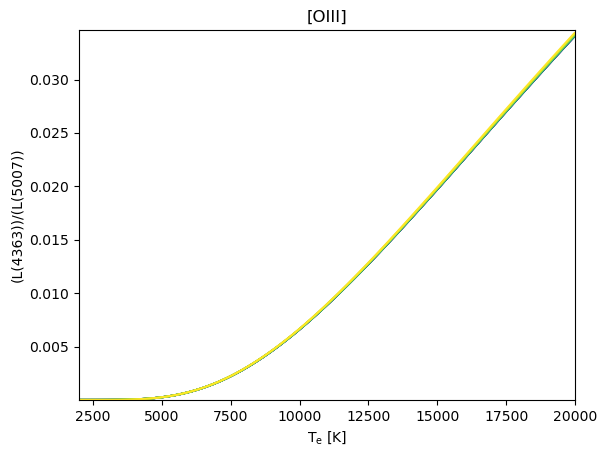

4363/5007 <=  0.010878323932312651
--> Te(4363) <  11785.284510009356
Abundance assuming Te = 12000 K: O++/H+ >= 8.788508839145446e-05
Metallicity (O3 only) >  7.943915193860167


In [38]:
# first up - OIII!

o3grid = pn.EmisGrid('O', 3, n_tem=100, n_den=100, tem_min=2000, tem_max=20000, den_min=100, den_max=5000)

o3grid.plotLineRatio(to_eval='(L(4363))/(L(5007))', par='den', n_par=10, legend=False,
                     par_low=2, par_high=3.5)

f_5007_dered = 74.46e-17#lines.loc[lines['restwave']==5008.24]['final_flux'].values[0]
dered_Hbeta = 17.12e-17#lines.loc[lines['restwave']==4862.683]['final_flux'].values[0]
f_4363_dered = 0.81e-17#lines.loc[lines['restwave']==4364.436]['final_flux'].values[0]
o3hbeta = f_5007_dered / dered_Hbeta
o3tem_ratio = (f_4363_dered)/f_5007_dered
print('4363/5007 <= ',o3tem_ratio)
o3tem = O3.getTemDen(o3tem_ratio,den=590,wave1=4363,wave2=5007)
print('--> Te(4363) < ', o3tem)
o3abund = O3.getIonAbundance(o3hbeta*100, tem=12000, den=590, wave=5008)
print('Abundance assuming Te = 12000 K: O++/H+ >=', o3abund)
print('Metallicity (O3 only) > ', 12+np.log10(o3abund))

In [61]:
# stopgap to redo some calcs...
dered_Hbeta = 1.712e-16
o2_7320_uplim = 0.09e-17
o2_7330_uplim = 0.09e-17
f_4959_dered = 22.72e-17
f_4959_dered_err = 0.87e-17
rc = rci

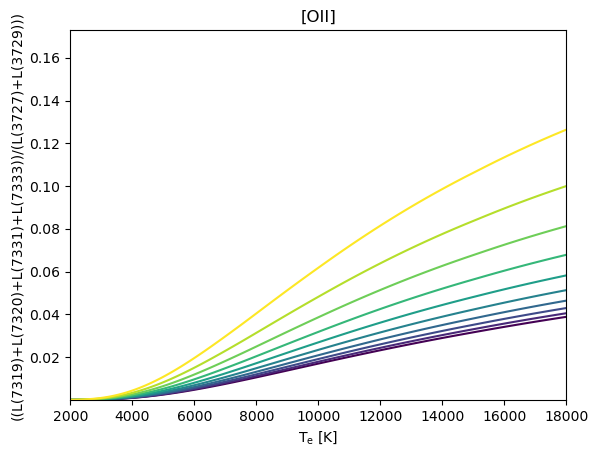

Hbeta ratio:0.6378139463773075
O3 ratio (4960): 0.34216269624551743
O3 ratio (5008): 0.3900865965045653
O2 w/ O3 ratio: 5.619125684525905e-16
Original 3727 Flux: 1.6422379605326482e-15 +- 1.212003458464469e-16
Updated 3727 Flux: 5.619125684525905e-16 +- 9.925528003149725e-17
O2 ratio <  0.003974130665891126
O2 temp <  4959.693600427473
O2 temp, TT < 11249.69915700655
OII Abundance (w/ Wuyts12) O+/H+ > 0.008885051371982228
OII Abundance w/ TT relation: 1.029106135158618e-05


In [96]:
o2grid = pn.EmisGrid('O', 2, n_tem=100, n_den=100, tem_min=2000, tem_max=18000, den_min=100, den_max=5000)

o2grid.plotLineRatio(to_eval='((L(7319)+L(7320)+L(7331)+L(7333))/(L(3727)+L(3729)))', par='den', n_par=10, legend=False,
                     par_low=2, par_high=3.5)


o2_3727_w = (9.6e-16) * gc.getCorr(3727*(1+zsource)) * rci.getCorr(3727)  #/ 0.76 # Blended 3727,9 from Wuyts+2012, dereddening from our calculations
o2_3727_w_err = o2_3727_w * np.sqrt((0.7e-16/9.6e-16)**2 + (rci.getErrCorr(3727,ebv_err)/rci.getCorr(3727))**2)
hbeta_w = 1.8e-16 * gc.getCorr(4861*(1+zsource)) * rci.getCorr(4861) #/ 0.55
hbeta_w_err = hbeta_w * np.sqrt((0.4e-16/1.8e-16)**2 + (rci.getErrCorr(4861,ebv_err)/rci.getCorr(4861))**2)
o3_5007_w = 13e-16 * gc.getCorr(5007*(1+zsource)) * rci.getCorr(5007) #/ 0.67
o3_4959_w = 4.5e-16 * gc.getCorr(4959*(1+zsource)) * rci.getCorr(4959) #/ 0.74
o3_4959_w_err = o3_4959_w * np.sqrt((0.7e-16/4.5e-16)**2 + (rci.getErrCorr(4959,ebv_err)/rci.getCorr(4959))**2)

hbeta_ratio = dered_Hbeta / hbeta_w
print(f'Hbeta ratio:{hbeta_ratio}')#,dered_Hbeta, hbeta_w)
o2_3727_w_scale = o2_3727_w * hbeta_ratio 

#f_4959_dered = lines.loc[lines['restwave']==4960.295]['final_flux'].values[0]
#f_4959_dered_err = lines.loc[lines['restwave']==4960.295]['final_fluxerr'].values[0]

o3ratiow = f_4959_dered / o3_4959_w
o3ratiow_err = o3ratiow * np.sqrt((f_4959_dered_err/f_4959_dered)**2 + (o3_4959_w_err/o3_4959_w)**2)
print(f'O3 ratio (4960): {o3ratiow}')
print(f'O3 ratio (5008): {f_5007_dered / o3_5007_w}')
print(f'O2 w/ O3 ratio: {o2_3727_w * o3ratiow}')
o2_3727_w_scale = o2_3727_w * o3ratiow
o2_3727_w_scale_err = o2_3727_w_scale * np.sqrt((o2_3727_w_err/o2_3727_w)**2 + (o3ratiow_err/o3ratiow)**2)
print(f'Original 3727 Flux: {o2_3727_w} +- {o2_3727_w_err}')
print(f'Updated 3727 Flux: {o2_3727_w_scale} +- {o2_3727_w_scale_err}')


o2_tem_ratio = (o2_7320_uplim*rci.getCorr(7320) + o2_7330_uplim*rci.getCorr(7330)) / (o2_3727_w_scale)
#o2_tem_ratio = (0.31e-17 + 0.31e-17) / (o2_3727_w_scale)
print('O2 ratio < ', o2_tem_ratio)
to2 = O2.getTemDen(o2_tem_ratio,den=600,to_eval='((L(7319)+L(7320)+L(7331)+L(7333))/(L(3727)+L(3729)))')
print('O2 temp < ', to2)
to2_tt = (0.7*(o3tem/1e4) + 0.3) * 1e4
print(f'O2 temp, TT < {to2_tt}')
o2_abund_ratio = (o2_7320_uplim*rci.getCorr(7320) + o2_7330_uplim*rci.getCorr(7330)) / dered_hbeta
o2abund = O2.getIonAbundance(int_ratio=o2_abund_ratio*100,
                               tem=to2, den=590,
                               to_eval='L(7319)+L(7320)+L(7331)+L(7332)')
o2abund_tt = O2.getIonAbundance(int_ratio=o2_abund_ratio*100,
                               tem=to2_tt, den=590,
                               to_eval='L(7319)+L(7320)+L(7331)+L(7332)')
print(f'OII Abundance (w/ Wuyts12) O+/H+ > {o2abund}')
print(f'OII Abundance w/ TT relation: {o2abund_tt}')

In [19]:
orig_o2 = 1.54e-15
orig_o2*0.5808


8.94432e-16

In [4]:
np.sqrt((1/74.5)**2 + (0.7e-16/13e-16)**2)*0.312

0.01731411763357593

In [5]:
1.5427222117509943e-15 * 0.312

4.813293300663102e-16

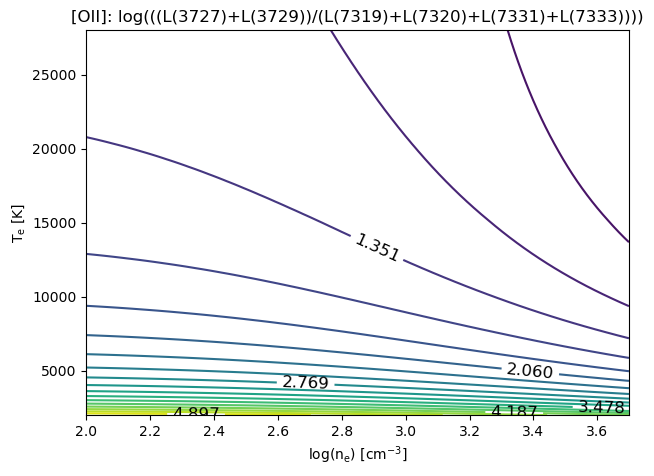

In [36]:
fig, ax = plt.subplots(figsize=(7,5))
o2grid.plotContours(to_eval ='((L(3727)+L(3729))/(L(7319)+L(7320)+L(7331)+L(7333)))', ax=ax)
plt.show()

In [37]:
print(f'Metallicity (O3 uplim, O2 TT): {12 + np.log10(o3abund+o2abund_tt)}')
print(f'Metallicity (O3 uplim, O2 uplim): {12 + np.log10(o3abund+o2abund)}')

Metallicity (O3 uplim, O2 TT): 8.044270747063324
Metallicity (O3 uplim, O2 uplim): 9.717365226342716


In [38]:
# some strong line diagnostics:
# up first, N2/Halpha
dered_n2_6585 = lines.loc[lines['restwave']==6585.28]['final_flux'].values[0]
dered_n2_6585_err = lines.loc[lines['restwave']==6585.28]['final_fluxerr'].values[0]
dered_halpha = lines.loc[lines['restwave']==6564.61]['final_flux'].values[0]
dered_halpha_err = lines.loc[lines['restwave']==6564.61]['final_fluxerr'].values[0]
N2Ha = dered_n2_6585 / dered_halpha
N2Ha_err = np.sqrt((dered_n2_6585_err/dered_n2_6585)**2 + (dered_halpha_err/dered_halpha)**2) * N2Ha
print(f'NII6585/Halpha: {N2Ha} +- {N2Ha_err}')
linear_pp04_metal = 8.90 + 0.57*np.log10(N2Ha) # equation 1, Pettini&Pagel 2004
linear_pp04_metalhi = (8.90 + 0.57*np.log10(N2Ha+N2Ha_err)) - linear_pp04_metal
linear_pp04_metallo = linear_pp04_metal - (8.90 + 0.57*np.log10(N2Ha-N2Ha_err)) 
print(f'12+log(O/H), N2: {linear_pp04_metal} +{linear_pp04_metalhi} -{linear_pp04_metallo}')

NII6585/Halpha: 0.05884817023504647 +- 0.01184504943963461
12+log(O/H), N2: 8.198747789411565 +0.04539753479105357 -0.055635573780508096


In [39]:
# now lets try N2 with the Kewley parametrization, just for funsies
log_n2 = np.log10(N2Ha)
log_n2_err = np.sqrt(N2Ha_err**2 / (N2Ha * np.log(N2Ha))**2) * N2Ha
print(log_n2, log_n2_err)

log_U = -2.8 #??
x = log_n2
y = log_U
A,B,C,D,E,F,G,H,I,J = [10.526,1.9958,-0.6741,0.2892,0.5712,-0.6597, 0.0101, 0.0800, 0.0782, -0.0982]
kewley_fit = A + B*x + C*y + D*x*y + E*x**2 + F*y**2 + G*x*y**2 + H*y*x**2 + I*x**3 + J*y**3
#print(kewley_fit, 0.0042*kewley_fit)
kewley_fit_err = np.sqrt((0.0067)**2 + (log_n2_err/log_n2)**2) * kewley_fit
#print(kewley_fit_err)
print(f'N2/Halpha: 12 + log(O/H) = {kewley_fit} +- {kewley_fit_err}')

-1.230267036120062 0.0041814008328859165
N2/Halpha: 12 + log(O/H) = 8.220447404874038 +- 0.061758307867088455


In [40]:
# up next, R23 = (OII3727,9 + OIII4959,5007) / Hbeta
o3_4959_w = 4.5e-16 * rci.getCorr(4959)
o3_4959_w_err = 0.7e-16
o3_5007_w = 13e-16 * rci.getCorr(5007)
o3_5007_w_err = 4e-16

r23num = (o2_3727_w + o3_4959_w + o3_5007_w)
r23 = r23num / hbeta_w
r23err1 = np.sqrt(o2_3727_w_err**2 + o3_4959_w_err**2 + o3_5007_w_err**2)
r23err = np.sqrt((r23err1/r23num)**2 + (hbeta_w_err/hbeta_w)**2)
print(r23, r23err)
log_r23 = np.log10(r23)
log_r23_err = np.sqrt(r23err**2 / (r23 * np.log(10))**2) * log_r23
print(log_r23, log_r23_err)

log_U = -2.8 #??
x = log_r23
y = log_U
A,B,C,D,E,F,G,H,I,J = [9.7757,-0.5059,0.9707,-0.1744,-0.0255,0.3838, -0.0378, 0.0806, -0.0852, 0.0462]
kewley_fit = A + B*x + C*y + D*x*y + E*x**2 + F*y**2 + G*x*y**2 + H*y*x**2 + I*x**3 + J*y**3
print(kewley_fit, 0.0042*kewley_fit)
kewley_fit_err = np.sqrt(0.0042**2 + (log_r23_err/log_r23)**2)*kewley_fit
#print(kewley_fit_err)
print(f'R23, Wuyts+12 fluxes: 12 + log(O/H) = {kewley_fit} +- {kewley_fit_err}')

15.588436338315253 0.2459643131292188
1.1928025536943234 0.008173770091557071
8.176125011285064 0.03433972504739727
R23, Wuyts+12 fluxes: 12 + log(O/H) = 8.176125011285064 +- 0.06571376907347987


In [41]:
# again, but with our OIII fluxes!
f_5007_dered = lines.loc[lines['restwave']==5008.24]['final_flux'].values[0]
f_5007_dered_err = lines.loc[lines['restwave']==5008.24]['final_fluxerr'].values[0]
f_4959_dered = lines.loc[lines['restwave']==4960.295]['final_flux'].values[0]
f_4959_dered_err = lines.loc[lines['restwave']==4960.295]['final_fluxerr'].values[0]
dered_Hbeta = lines.loc[lines['restwave']==4862.683]['final_flux'].values[0]
dered_Hbeta_err = lines.loc[lines['restwave']==4862.683]['final_fluxerr'].values[0]

o2_3727_w_scale_err = np.sqrt((o2_3727_w_err/o2_3727_w)**2 + (hbeta_w_err/hbeta_w)**2 + (dered_Hbeta_err/dered_Hbeta)**2) * o2_3727_w
#print(o2_3727_w_scale_err,o2_3727_w_err)

r23num = (o2_3727_w_scale + f_4959_dered + f_5007_dered)
r23 = r23num / dered_Hbeta
r23err1 = np.sqrt(o2_3727_w_scale_err**2 + f_4959_dered_err**2 + f_5007_dered_err**2)
r23err = np.sqrt((r23err1/r23num)**2 + (dered_Hbeta_err/dered_Hbeta)**2)
print(r23, r23err)
log_r23 = np.log10(r23)
log_r23_err = np.sqrt(r23err**2 / (r23 * np.log(10))**2) * log_r23
print(log_r23, log_r23_err)

log_U = -2.8 #??
x = log_r23
y = log_U
A,B,C,D,E,F,G,H,I,J = [9.7757,-0.5059,0.9707,-0.1744,-0.0255,0.3838, -0.0378, 0.0806, -0.0852, 0.0462]
kewley_fit = A + B*x + C*y + D*x*y + E*x**2 + F*y**2 + G*x*y**2 + H*y*x**2 + I*x**3 + J*y**3
print(kewley_fit, 0.0042*kewley_fit)
kewley_fit_err = np.sqrt(0.0042**2 + (log_r23_err/log_r23)**2)*kewley_fit
#print(kewley_fit_err)
print(f'R23, Wuyts+12 fluxes: 12 + log(O/H) = {kewley_fit} +- {kewley_fit_err}')

8.92245019380747 0.2809384024095015
0.9504841323503147 0.012997390233979209
8.454081072110004 0.035507140502862015
R23, Wuyts+12 fluxes: 12 + log(O/H) = 8.454081072110004 +- 0.12093526935379387


In [2]:
# also for funsies, let's try the Sanders+ R23 calibration:
log_r23, log_r23_err = 0.9504841323503147, 0.012997390233979209 # copied from above
c0 = 1.017
c1 = 0.026
c2 = -0.331

y = c0 - log_r23

# thanks to the quadratic formula, we now have:
met1 = ((-c1 + np.sqrt(c1**2 - 4*c2*y)) / (2*c2)) + 8
met2 = ((-c1 - np.sqrt(c1**2 - 4*c2*y)) / (2*c2)) + 8
print(met1, met2)

sandmeterr = np.sqrt(0.02**2 + (log_r23_err/log_r23)**2)*met2
print(sandmeterr)

7.58927847712778 8.48927137181482
0.20567733472455774


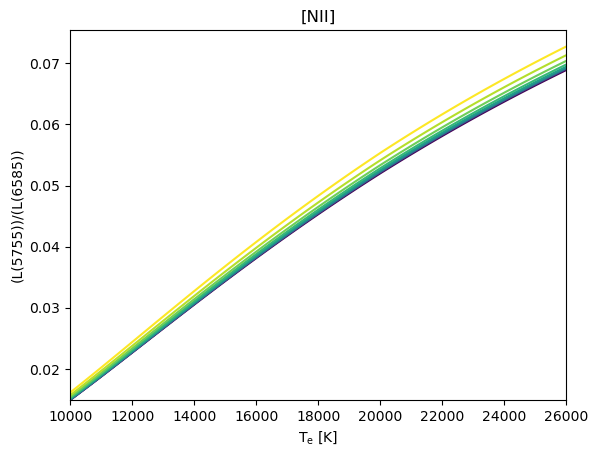

NII 5755/6585 <=  0.08949602750161027
--> Te(5755) <  35889.78085467619
NII given G92 T-T rel (T(N+)=T(O+)): Te <=  5561.769752395591
Abundance assuming Te = 22000 K: N+/H+ >= 8.437536342318599e-07
N+/O+ assuming Te


In [47]:
n2grid = pn.EmisGrid('N', 2, n_tem=100, n_den=100, tem_min=10000, tem_max=26000, den_min=100, den_max=5000)

n2grid.plotLineRatio(to_eval='(L(5755))/(L(6585))', par='den', n_par=10, legend=False,
                     par_low=2, par_high=3.5)



f_6585_dered = lines.loc[lines['restwave']==6585.28]['final_flux'].values[0]
dered_Hbeta = lines.loc[lines['restwave']==4862.683]['final_flux'].values[0]
n2hbeta = f_6585_dered / dered_Hbeta
n2tem_ratio = (n2_5755_uplim*rc.getCorr(5755))/f_6585_dered
print('NII 5755/6585 <= ',n2tem_ratio)
n2tem = N2.getTemDen(n2tem_ratio,den=590,wave1=5755,wave2=6585)
print('--> Te(5755) < ', n2tem)
print('NII given G92 T-T rel (T(N+)=T(O+)): Te <= ',to2)
n2abund = N2.getIonAbundance(n2hbeta*100, tem=22000, den=590, wave=6585)
print('Abundance assuming Te = 22000 K: N+/H+ >=', n2abund)
print('N+/O+ assuming Te')

In [48]:
# and now lets try SIII
ts3_tt = 0.83 * o3tem + 1700 #G92 TT relation
print(f'Te(S3) TT: < {ts3_tt} ')

Te(S3) TT: < 11404.844582662467 


In [49]:
# Calculate expected fluxes based on Strom+23 percentages of Halpha
strom_n2 = 0.002
strom_s3 = 0.0034
strom_o2a = 0.0121
strom_o2b = 0.0095
strom_n2_low = 0.0015
strom_s3_low = 0.0029
strom_o2a_low = 0.011
strom_o2b_low = 0.0088
strom_n2_hi = 0.0025
strom_s3_hi = 0.0041
strom_o2a_hi = 0.0138
strom_o2b_hi = 0.0112

halpha = lines.loc[lines['restwave']==6564.61]['flux'].values[0]
halpha_err = lines.loc[lines['restwave']==6564.61]['fluxerr'].values[0]

n2_expect = strom_n2 * halpha
n2_expect_low = strom_n2_low * halpha
n2_expect_hi = strom_n2_hi * halpha

s3_expect = strom_s3 * halpha
s3_expect_low = strom_s3_low * halpha
s3_expect_hi = strom_s3_hi * halpha

o2a_expect = strom_o2a * halpha
o2a_expect_low = strom_o2a_low * halpha
o2a_expect_hi = strom_o2a_hi * halpha

o2b_expect = strom_o2b * halpha
o2b_expect_low = strom_o2b_low * halpha
o2b_expect_hi = strom_o2b_hi * halpha

print(f'Strom [NII]: {n2_expect:.2e} [{n2_expect_low:.2e} -- {n2_expect_hi:.2e}], \n [NII] uplim: {n2_5755_uplim:.2e}')
print(f'Strom [SIII]: {s3_expect:.2e} [{s3_expect_low:.2e} -- {s3_expect_hi:.2e}], \n [SIII] uplim: {s3_6312_uplim:.2e}')
print(f'Strom [OII]7320: {o2a_expect:.2e} [{o2a_expect_low:.2e} -- {o2a_expect_hi:.2e}], \n [OII] uplim: {o2_7320_uplim:.2e}')
print(f'Strom [OII]7330: {o2b_expect:.2e} [{o2b_expect_low:.2e} -- {o2b_expect_hi:.2e}], \n [OII] uplim: {o2_7330_uplim:.2e}')

Strom [NII]: 7.91e-19 [5.93e-19 -- 9.88e-19], 
 [NII] uplim: 1.25e-18
Strom [SIII]: 1.34e-18 [1.15e-18 -- 1.62e-18], 
 [SIII] uplim: 1.03e-18
Strom [OII]7320: 4.78e-18 [4.35e-18 -- 5.46e-18], 
 [OII] uplim: 8.15e-19
Strom [OII]7330: 3.76e-18 [3.48e-18 -- 4.43e-18], 
 [OII] uplim: 8.24e-19


In [44]:
halpha, halpha_err

(3.9532333345816083e-16, 6.359963361078821e-18)

## HERE BE DRAGONS
This is all old code, random testing, and other not-to-be-trusted gobbledygook

In [7]:
# Now we'll read in the spectrum as a Spectrum1D object
spec = Spectrum1D.read(os.path.join(datadir, cubefile), format="JWST s3d")

with fits.open(os.path.join(datadir, cubefile)) as cubehdu:
    header = cubehdu[1].header
    pixar_sr = header["PIXAR_SR"] * u.sr

    
# Now let's read in the mask we'll use to extract the final 1D spectrum
# DONT FORGET .T BECAUSE PYTHON IS WEIRD
SNRmask = fits.open(os.path.join(maskdir,maskfile))[0].data.T ##.T!!!!!
##SNRmask = np.ones(spec.shape[:2])

<IPython.core.display.Javascript object>


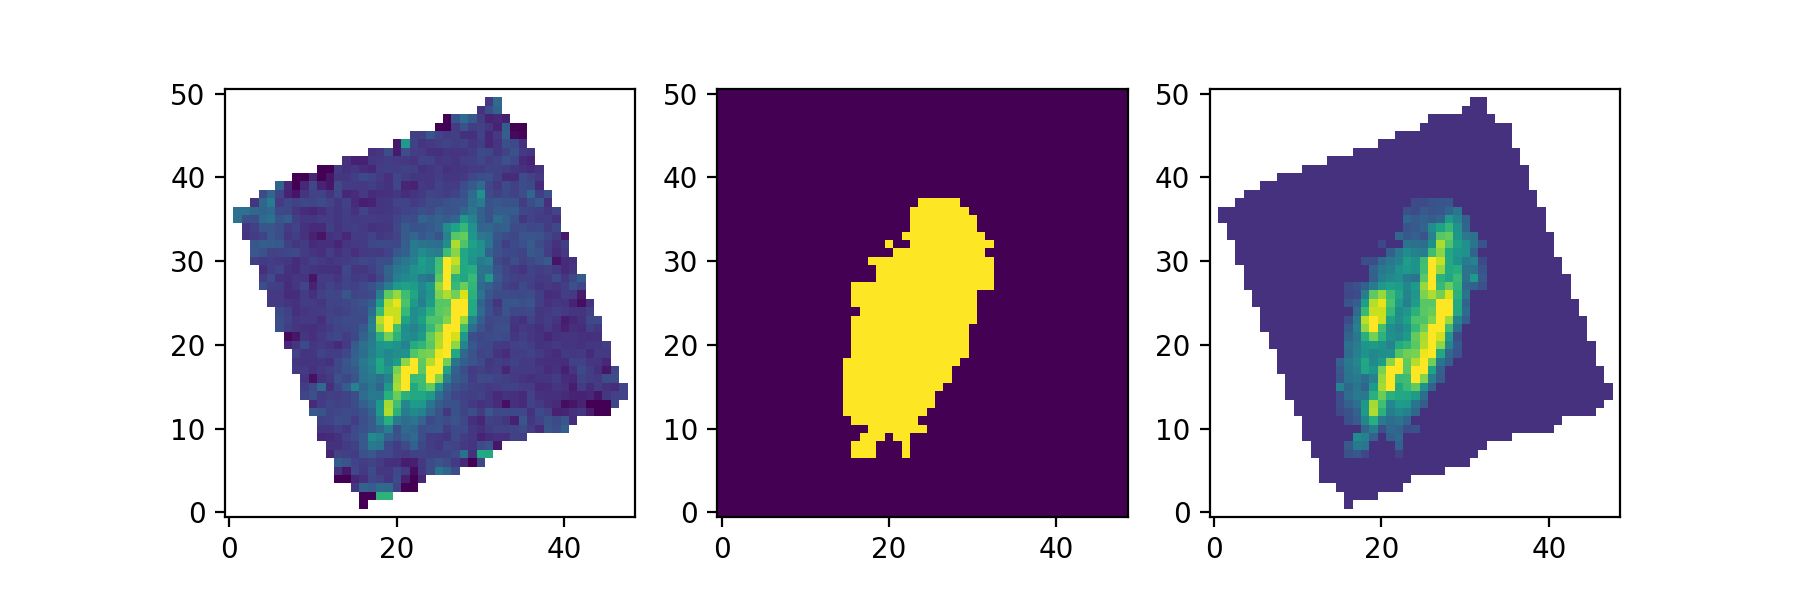

In [8]:
# Consistency check - does the mask line up with the data??
imslice = spec[:,:,788].flux
imslice.shape = (imslice.shape[:2])
imslice_cut = imslice * SNRmask

fig, ax = plt.subplots(1,3, figsize=(9,3))

ax[0].imshow(imslice, origin='lower', vmin=-2, vmax=12)

ax[1].imshow(SNRmask, origin='lower')

ax[2].imshow(imslice_cut, origin='lower', vmin=-2, vmax=12)

plt.show()

<IPython.core.display.Javascript object>


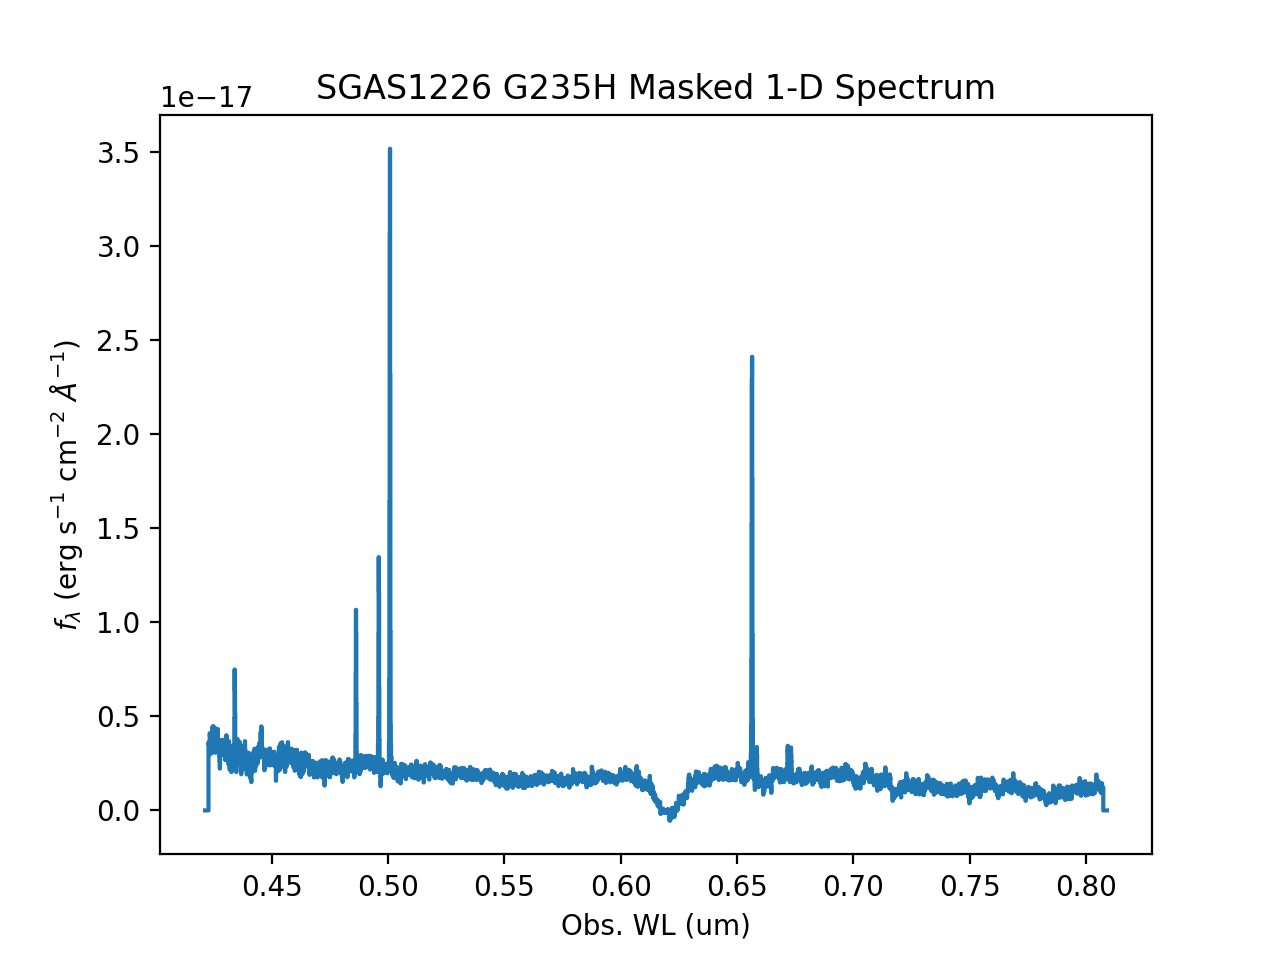

In [13]:
# extract the 1-D spectrum:
spectrum = bws.extract1D_cube_mask(spec, SNRmask, pixar_sr, zsource=2.926)

# for convenience, extract the wavelength array
wlarray = spectrum.spectral_axis

# and plot it for funsies:
fig = plt.figure()
plt.step(spectrum.spectral_axis, spectrum.flux, where='mid')
plt.xlabel("Obs. WL (um)")
plt.ylabel("$f_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ $\AA ^{-1}$)")
plt.title('SGAS1226 G235H Masked 1-D Spectrum')
#plt.ylim(-5e-17, 5e-17)
plt.show()

<IPython.core.display.Javascript object>


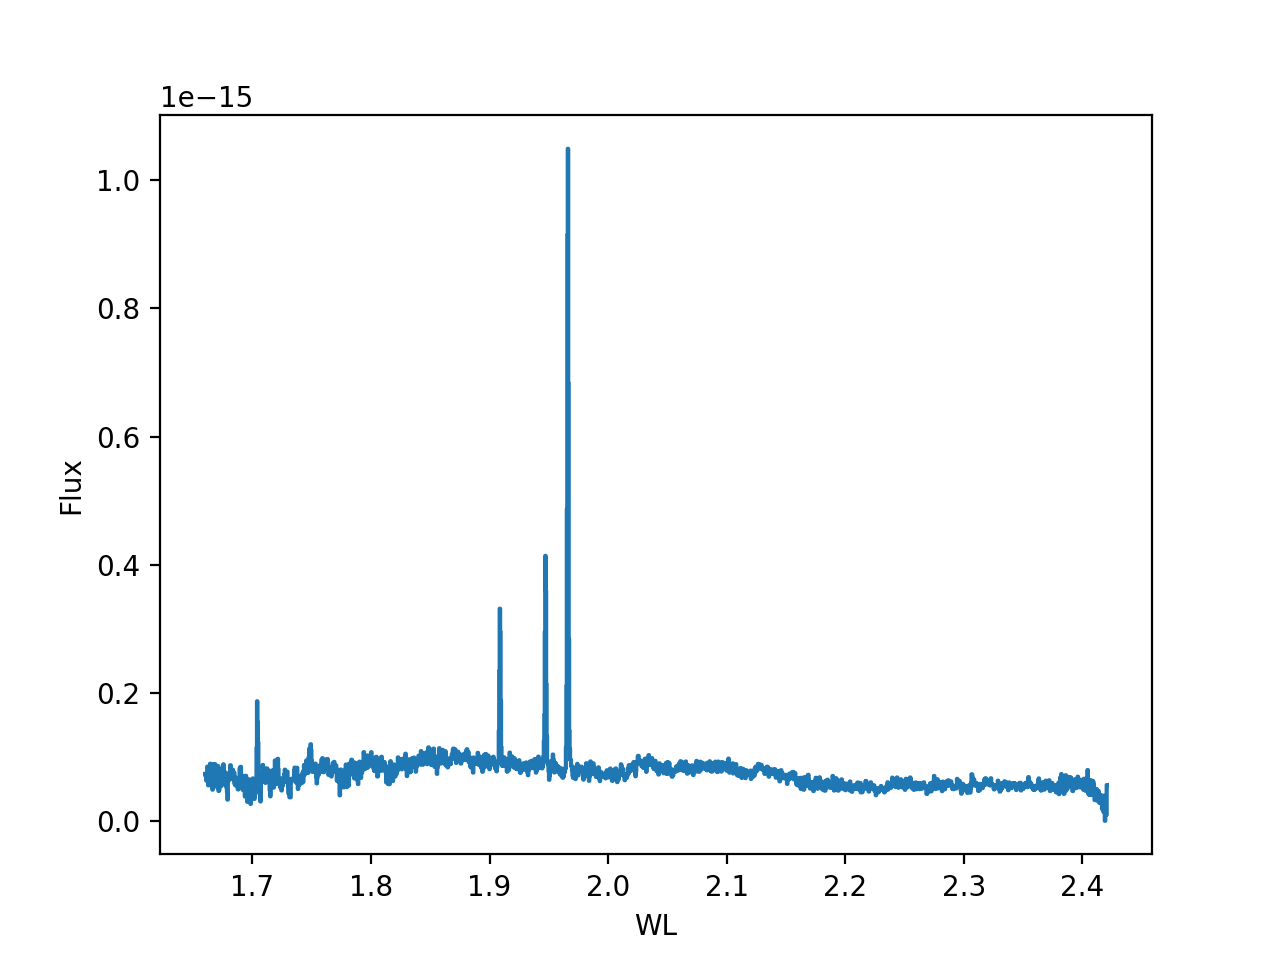

In [49]:
tversion = np.loadtxt('/Users/bdwelch1/Documents/data/templates/sdss1226/nirspec/SGAS1226-coadd-spectrum1D-LAYERS-g235h.txt',
                     skiprows=16, max_rows=1922)
twl = tversion[:,0]
tflux = tversion[:,1]

fig = plt.figure()
plt.step(twl, tflux, where='mid')
plt.xlabel('WL')
plt.ylabel('Flux')
plt.show()

<IPython.core.display.Javascript object>


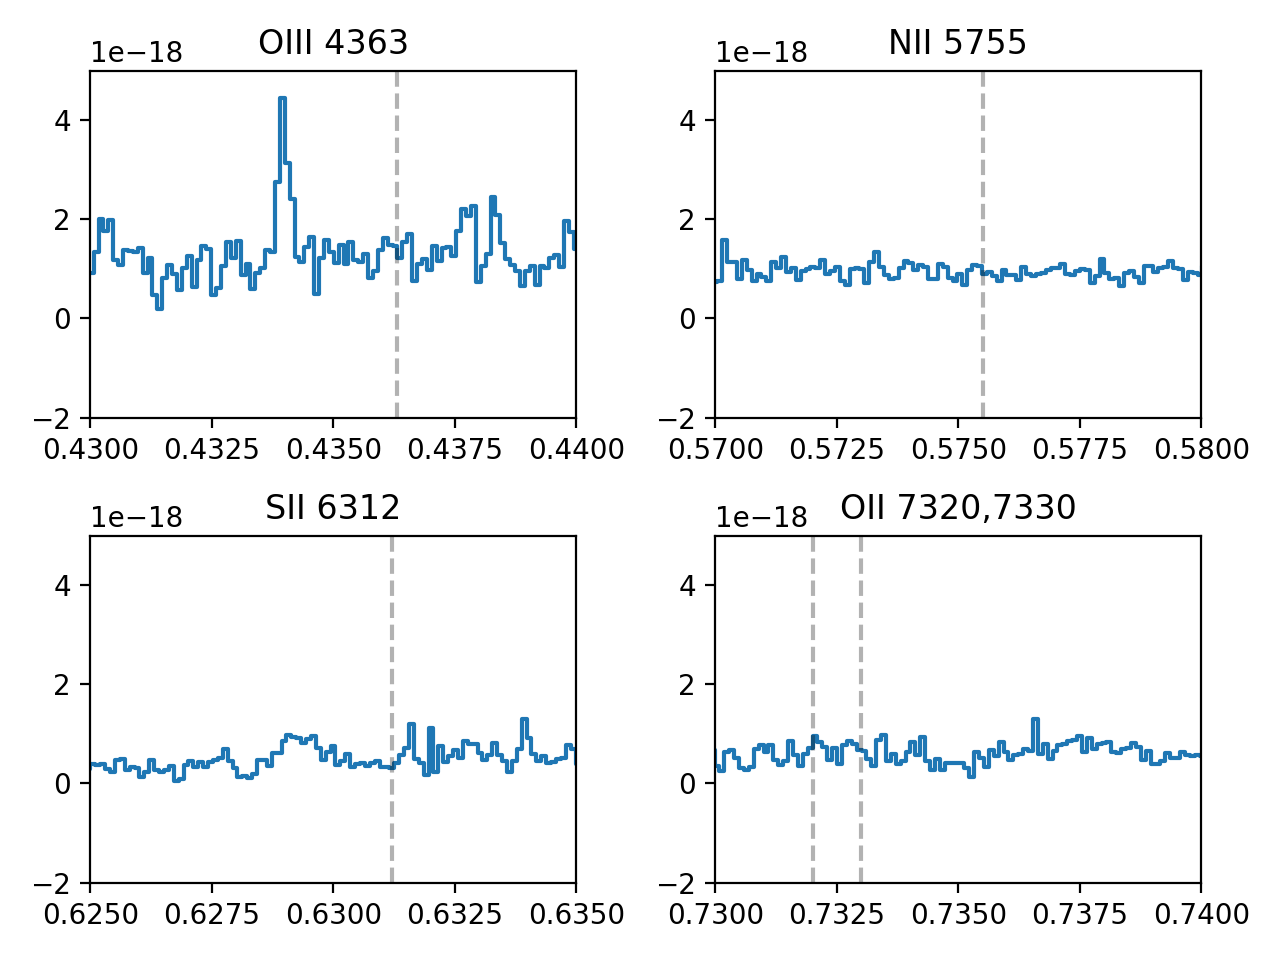

In [37]:
# also for funsies, plot zoom-ins around each auroral line
fig, ax = plt.subplots(2,2)

ax[0][0].step(spectrum.spectral_axis, spectrum.flux, where='mid')
ax[0][0].set_title('OIII 4363')
ax[0][0].set_xlim(.43,.44)
ax[0][0].set_ylim(-2e-18, 5e-18)
ax[0][0].vlines(0.4363, -2e-18, 5e-18, color='k', linestyles='--', alpha=0.3)

ax[0][1].step(spectrum.spectral_axis, spectrum.flux, where='mid')
ax[0][1].set_title('NII 5755')
ax[0][1].set_xlim(.57,.58)
ax[0][1].set_ylim(-2e-18, 5e-18)
ax[0][1].vlines(0.5755, -2e-18, 5e-18, color='k', linestyles='--', alpha=0.3)

ax[1][0].step(spectrum.spectral_axis, spectrum.flux, where='mid')
ax[1][0].set_title('SII 6312')
ax[1][0].set_xlim(.625,.635)
ax[1][0].set_ylim(-2e-18, 5e-18)
ax[1][0].vlines(0.6312, -2e-18, 5e-18, color='k', linestyles='--', alpha=0.3)

ax[1][1].step(spectrum.spectral_axis, spectrum.flux, where='mid')
ax[1][1].set_title('OII 7320,7330')
ax[1][1].set_xlim(.73,.74)
ax[1][1].set_ylim(-2e-18, 5e-18)
ax[1][1].vlines([0.7320,0.7330], -2e-18, 5e-18, color='k', linestyles='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# test is_line and upper_limit:
# first - is there a line at OIII 5008?? (there flippin better be)
cont5008 = SpectralRegion(0.494*u.um, 0.495*u.um) + SpectralRegion(0.502*u.um, 0.503*u.um)
line5008 = SpectralRegion(0.5*u.um, 0.502*u.um)
print("Is there OIII 5008?",bws.is_line(spectrum, line5008, cont5008), "- Great Success!!")
print()

#next, is there a line at NII 5755? 
cont5755 = SpectralRegion(0.5715*u.um, 0.574*u.um) + SpectralRegion(0.577*u.um, 0.585*u.um)
line5755 = SpectralRegion(0.574*u.um, 0.577*u.um)
isline5755 = bws.is_line(spectrum, line5755, cont5755)
print("Is there NII 5755?", isline5755)
# if no line, we take an upper limit:
if not isline5755:
    uplim5755, sig5755, peak5755 = bws.flux_upper_limit(spectrum, line5755, cont5755, verbose=True)
    print("NII5755 upper limit:", uplim5755)
    print("noise sigma:", sig5755)
    print("NII peak:", peak5755)
print()

# okay, now for a more interesting test - is there a line at SIII 6312?
cont6312 = SpectralRegion(0.626*u.um, 0.629*u.um) + SpectralRegion(0.6325*u.um, 0.634*u.um)
line6312 = SpectralRegion(0.6309*u.um, 0.6319*u.um)
isline6312 = bws.is_line(spectrum, line6312, cont6312, n=3)
print("Is there SIII 6312?", isline6312)
if not isline6312:
    uplim6312, sig6312, peak6312 = bws.flux_upper_limit(spectrum, line6312, cont6312, verbose=True)
    print("uplim:", uplim6312)
    print("sigma:", sig6312)
    print("SIII peak:", peak6312)
print()

Is there OIII 5008? True - Great Success!!

Is there NII 5755? True

Is there SIII 6312? True



<IPython.core.display.Javascript object>


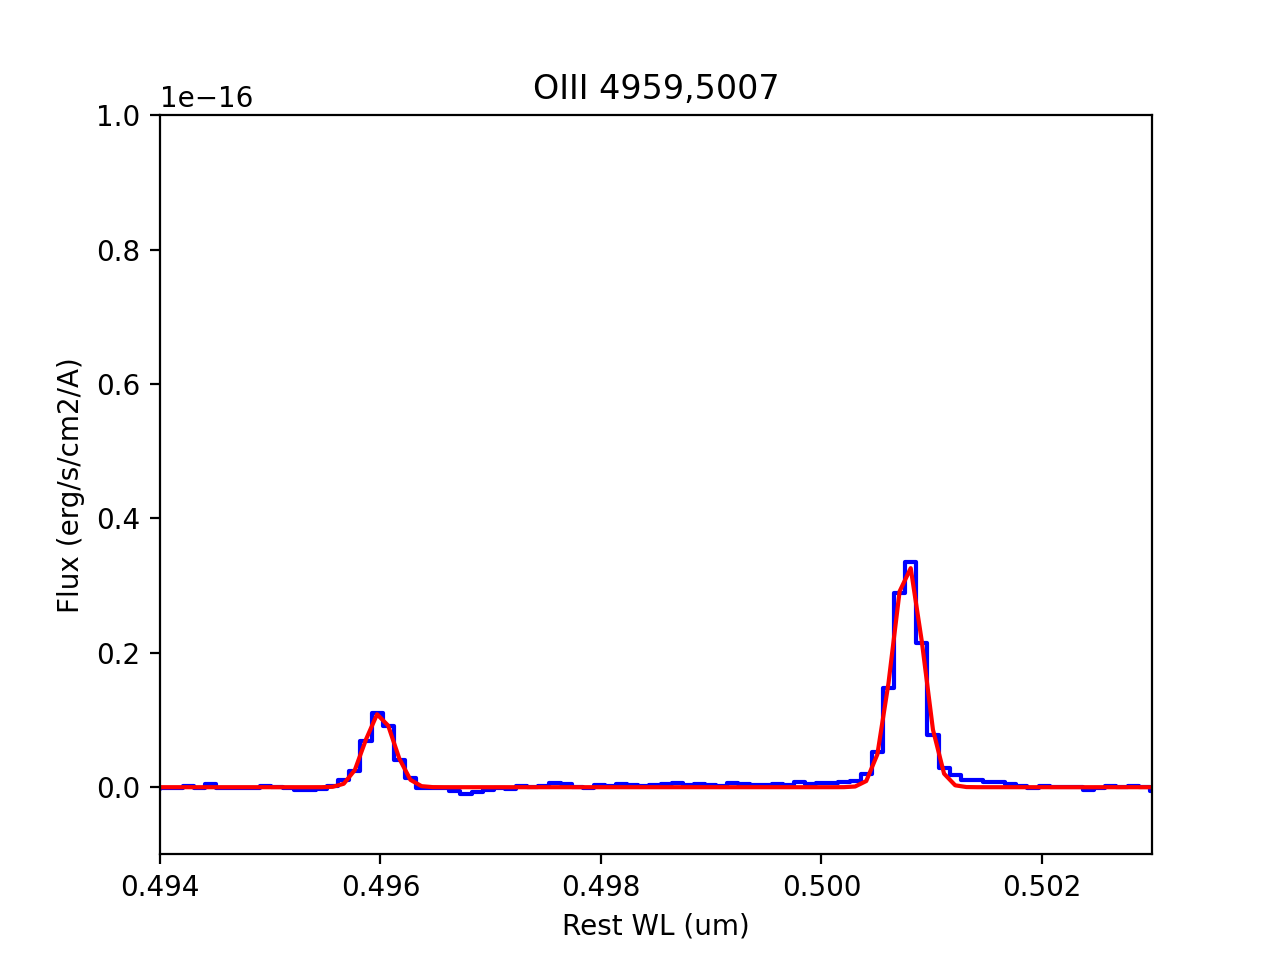

4959 flux,err: 3.606660448338604e-17 2.5481098288796566e-18
5007 flux,err: 1.1667046697056924e-16 2.9789077087415012e-18
Ratio:  3.234861408267948


In [16]:
scale=1e16
cont5008 = SpectralRegion(0.494*u.um, 0.495*u.um) + SpectralRegion(0.502*u.um, 0.503*u.um)
line5008 = SpectralRegion(0.495*u.um, 0.502*u.um) 
param_dictOIII = {
    "amplitude": [1,1],
    "wavelength": [4960, 5008],
    "width": [1, 1]
}

f,ferr,poptOIII,pcovOIII,contsub5008 = bws.cont_sub_curvefit(spectrum,
                                                                                   cont5008, 
                                                                                   line5008,
                                                                                   line_param_dict=param_dictOIII,
                                                                                     scale=scale,
                                                                                   verbose=True)
fitresOIII = bws.multigauss2(wlarray.value, poptOIII[0]/scale, poptOIII[1]/1e4,
                     poptOIII[2]/1e4,poptOIII[3]/scale,poptOIII[4]/1e4, poptOIII[5]/1e4)

fig = plt.figure()

plt.step(contsub5008.spectral_axis, contsub5008.flux, 'b-', where='mid')
#plt.plot(contsub7330.spectral_axis, fit7330(wlarray), 'r-')
#plt.plot(contsub7320.spectral_axis, fit7320(wlarray), 'r-')
plt.plot(wlarray, fitresOIII, 'r-')
plt.xlabel('Rest WL (um)')
plt.ylabel('Flux (erg/s/cm2/A)')
plt.title('OIII 4959,5007')
plt.xlim(0.494, 0.503)
plt.ylim(-1e-17, 1e-16)
plt.show()

print("4959 flux,err:",f[0], ferr[0])
print("5007 flux,err:",f[1], ferr[1])
print('Ratio: ', f[1]/f[0])

In [17]:
(f[1]-ferr[1]) / (f[0]+ferr[0])

2.9442548335962804

/Users/bdwelch1/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<IPython.core.display.Javascript object>


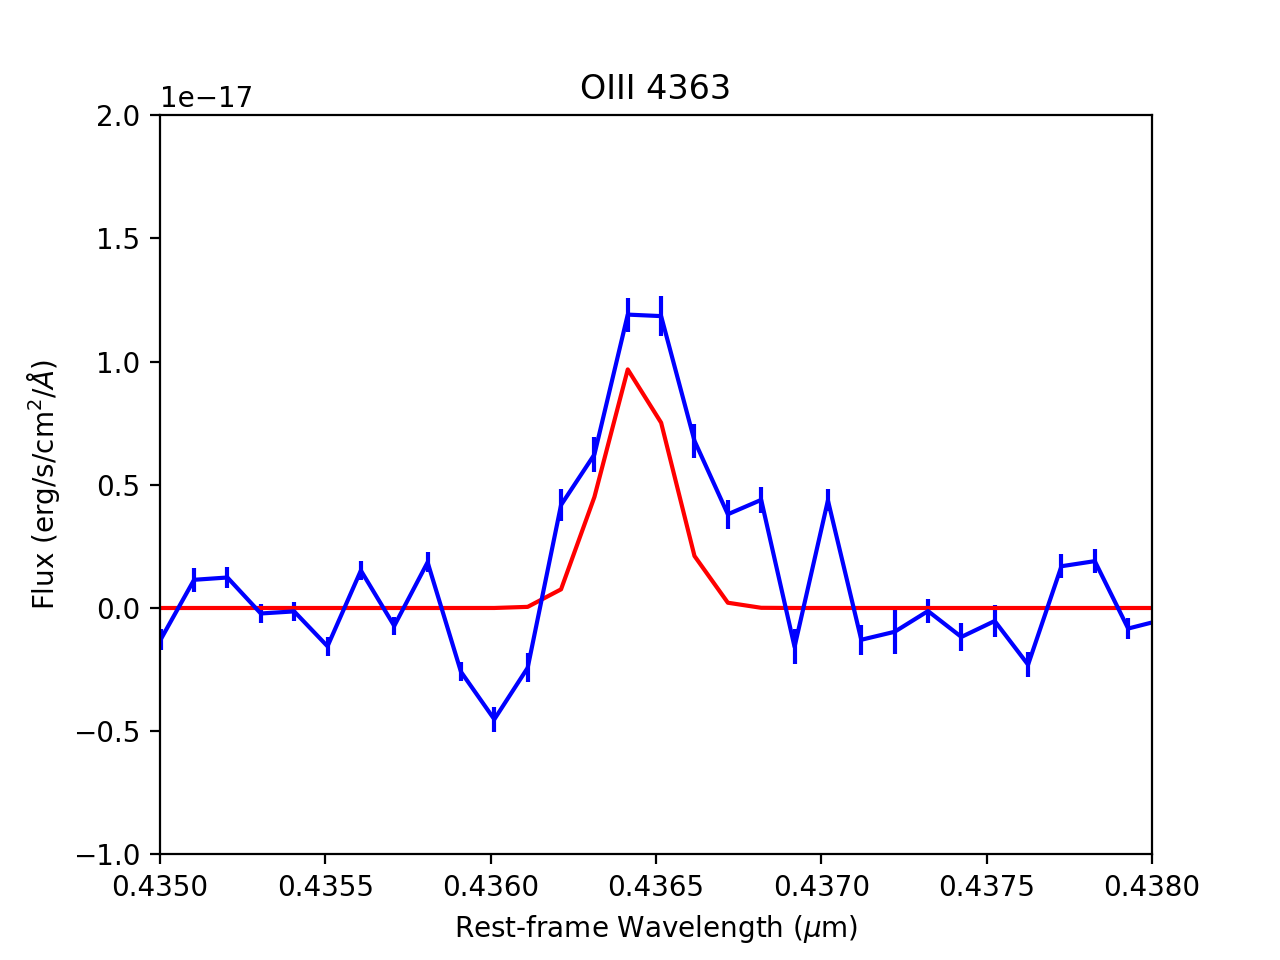

2.5066282746310005e-21 inf


In [59]:
scale = 1e17
cont4363 = SpectralRegion(0.435*u.um, 0.436*u.um) + SpectralRegion(0.437*u.um, 0.438*u.um)
flux4363, fluxerr4363, popt, pcov, contsub4363 = bws.cont_sub_curvefit(spectrum, 
                               cont_region = cont4363, 
                               line_region = SpectralRegion(0.436*u.um, 0.437*u.um), 
                               line_params = [1, 0.43644, 0.0001],
                               verbose=True,
                                scale=scale)

fitflux = bws.gaussian(wlarray.value, popt[0]/scale,popt[1],popt[2])
fig = plt.figure()

plt.errorbar(contsub4363.spectral_axis, contsub4363.flux.value, yerr=contsub4363.uncertainty.array, fmt='b-')
plt.plot(contsub4363.spectral_axis, fitflux, 'r-')
plt.xlabel('Rest-frame Wavelength ($\mu$m)')
plt.ylabel('Flux (erg/s/cm$^2$/$\AA$)')
plt.title('OIII 4363')
plt.xlim(0.435, 0.438)
plt.ylim(-1e-17, 2e-17)
plt.show()

print(flux4363, fluxerr4363)